# Perch Multi Seed Validation
#### 5 Random (but reproducible) seeds are selected for 5 different runs of train/test
#### Models have been optimised and verified on validation sets thoroughly, running a final train/test evaluation here
#### The setup:

- 4 fold StratifiedGroupKFold for stratification and ensuring each cat_id group only appears in one set at a time
- Final scores averaged over the 4 folds
- For each seed run we will explore the cat_id predictions through majority voting
- For each run we will explore the potential impact of gender
- Includes visualisations & analysis

The dataset is highly unbalanced.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import random
from datetime import datetime
from collections import Counter

# Sklearn imports
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.inspection import permutation_importance

# Imbalanced-learn import
from imblearn.over_sampling import SMOTE

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, concatenate
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax, AdamW
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from keras.regularizers import l1, l2, L1L2

# Optuna import
import optuna

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import statistical tests
from scipy.stats import levene

from IPython.display import display
import time

In [2]:
# Track running time (including analysis)
start_time = time.time()

In [3]:
# Set an initial seed for reproducibility
np.random.seed(42)  

# Generate a list of 5 random seeds
random_seeds = np.random.randint(0, 10000, size=5)
print("Random Seeds:", random_seeds)

Random Seeds: [7270  860 5390 5191 5734]


#### TOTAL RESULTS ACROSS SEED INITIATION

In [4]:
# Lists to collect statistics across all CVs
all_losses, all_accuracies, all_precisions, all_recalls, all_f1 = [], [], [], [], []
average_fold_losses, average_fold_accuracies, average_fold_precisions, average_fold_recalls, average_fold_f1 = [], [], [], [], []
all_majority_vote_accuracies, all_majority_vote_details, all_class_stats, all_gender_stats  = [], [], [], []

# training accuracies
all_best_training_acc = []
total_training_acc = []

## Define Functions

In [5]:
def check_initial_group_split(groups_train, groups_test):
    """
    Check if any group is present in both the train and test sets.

    Parameters:
    - groups_train: Array of group identifiers for the train set
    - groups_test: Array of group identifiers for the test set

    Returns:
    - Prints out any groups found in both sets and the count of such groups
    """
    train_groups = set(groups_train)
    test_groups = set(groups_test)
    common_groups = train_groups.intersection(test_groups)

    if common_groups:
        print(f"Warning: Found {len(common_groups)} common groups in both train/validation and test sets: {common_groups}")
    else:
        print("No common groups found between train and test sets.")


In [6]:
# Function to perform the swaps based on cat_id, ensuring swaps within the same age_group
def swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids):
    for cat_id in specific_cat_ids:
        # Check if the specific cat_id is not in the training set
        if cat_id not in dataframe.iloc[train_val_idx]['cat_id'].values:
            # Get the age_group of this cat_id
            age_group = dataframe[dataframe['cat_id'] == cat_id]['age_group'].iloc[0]
                
            # Find a different cat_id within the same age_group in the train set that is not in the test set
            other_cat_ids_in_age_group = dataframe[(dataframe['age_group'] == age_group) & 
                                                   (dataframe['cat_id'] != cat_id) &
                                                   (~dataframe['cat_id'].isin(dataframe.iloc[test_idx]['cat_id']))]['cat_id'].unique()
            
            # Choose one other cat_id for swapping
            if len(other_cat_ids_in_age_group) > 0:
                other_cat_id = np.random.choice(other_cat_ids_in_age_group)

                # Find all instances of the other_cat_id in the train set
                other_cat_id_train_val_indices = train_val_idx[dataframe.iloc[train_val_idx]['cat_id'] == other_cat_id]
                
                # Find all instances of the specific cat_id in the test set
                cat_id_test_indices = test_idx[dataframe.iloc[test_idx]['cat_id'] == cat_id]
                
                # Swap the indices
                train_val_idx = np.setdiff1d(train_val_idx, other_cat_id_train_val_indices, assume_unique=True)
                test_idx = np.setdiff1d(test_idx, cat_id_test_indices, assume_unique=True)

                train_val_idx = np.concatenate((train_val_idx, cat_id_test_indices))
                test_idx = np.concatenate((test_idx, other_cat_id_train_val_indices))
            else:
                print(f"No alternative cat_id found in the same age_group as {cat_id} for swapping.")
                
    return train_val_idx, test_idx

In [7]:
# Function to identify differences in groups
def find_group_differences(original, new):
    # Convert numpy arrays to sets for easy difference computation
    original_set = set(original)
    new_set = set(new)
    # Find differences
    moved_to_new = new_set - original_set
    moved_to_original = original_set - new_set
    return moved_to_new, moved_to_original

In [8]:
# create custom logger function for local logs & stored in a .txt
def logger(message, file=None):
    print(message)
    if file is not None:
        with open(file, "a") as log_file:
            log_file.write(message + "\n")

log_file_path = "perch_categorical-logs.txt" 

In [9]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid", palette="deep")

# Define a custom color palette
colors = ["#6aabd1", "#b6e2d3", "#dac292"] 
sns.set_palette(sns.color_palette(colors))

# Function to create bar plots with enhanced style
def styled_barplot(data, x, y, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 

    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        # Annotate the height value on the bar
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")

    plt.show()

In [10]:
def styled_barplot_with_average(data, x, y, title, xlabel, ylabel, average_line=None):
    plt.figure(figsize=(8, 4))
    bar_plot = sns.barplot(x=x, y=y, data=data, errorbar=None, width=0.5)  
    plt.title(title, fontsize=16, fontweight='bold', color="#333333")
    plt.xlabel(xlabel, fontsize=14, fontweight='bold', color="#333333")
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color="#333333")
    plt.xticks(fontsize=12, color="#333333")
    plt.yticks(fontsize=12, color="#333333")
    plt.ylim(0, 100) 
    
    # Adding value labels on top of each bar
    for p in bar_plot.patches:
        height = p.get_height()
        bar_plot.annotate(f'{height:.1f}', 
                          (p.get_x() + p.get_width() / 2., height), 
                          ha='center', va='center', 
                          xytext=(0, 9), 
                          textcoords='offset points', fontsize=12, color="#333333")
    
    if average_line is not None:
        plt.axhline(y=average_line, color='red', linestyle='--', 
                    label=f'Macro-Averaged Accuracy: {average_line:.1f}%')
        plt.legend(fontsize=10)
    
    plt.show()

In [11]:
def plot_all_metrics(losses, accuracies, precisions, recalls, f1, metrics_across, x_axis_label):
    fig, ax = plt.subplots(figsize=(12, 8))
    seeds = range(1, len(losses) + 1)

    ax.plot(seeds, losses, marker='o', color='blue', label='Loss')
    ax.plot(seeds, accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(seeds, precisions, marker='o', color='red', label='Precision')
    ax.plot(seeds, recalls, marker='o', color='purple', label='Recall')
    ax.plot(seeds, f1, marker='o', color='orange', label='F1 Score')

    ax.set_title(f'Metrics Across {metrics_across}')
    ax.set_xlabel(x_axis_label)
    ax.set_ylabel('Metric Value')
    ax.set_xticks(seeds)
    ax.legend()
    ax.grid(True)

    return fig

In [12]:
# store epoch accs
class AccuracyHistory(Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('accuracy'))

# RANDOM SEED 1

## Prepare Data

In [13]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[0])) 
np.random.seed(int(random_seeds[0]))
tf.random.set_seed(int(random_seeds[0]))

# Load datasets
dataframe = pd.read_csv('perch_looped_embeddings.csv')

def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     405
senior    253
kitten    135
Name: age_group, dtype: int64


In [14]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [15]:
tf.keras.backend.clear_session()

## Run Setup

In [16]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[0]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )

    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adam': Adam(learning_rate=0.007402414884293732)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(512, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.15688606637942396))  
    model_full.add(Dense(64, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.28869063762474007))  
    model_full.add(Dense(128, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27322054853254163))   
    model_full.add(Dense(32, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.4064145271744943))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adam']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
000A    39
103A    33
047A    22
000B    19
057A    17
        ..
049A     1
064A     1
096A     1
043A     1
026B     1
Name: cat_id, Length: 82, dtype: int64
Testing Set Group Distribution:
046A    45
002B    30
020A    20
074A    16
106A    13
111A    12
028A    11
067A    11
063A    11
005A     9
036A     7
023A     6
050A     5
070A     5
003A     4
025C     4
056A     3
012A     3
010A     3
093A     2
032A     2
038A     2
061A     2
037A     2
076A     1
073A     1
041A     1
019B     1
090A     1
024A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
F    212
X    184
M    163
Name: gender, dtype: int64
Testing Set Gender Distribution BEFORE SWAP:
M    123
X     92
F     19
Name: gender, dtype: int64
Unique Cat IDs per Age Group in Training/Validation Set:
age_group
adult     [006A, 000A, 033A, 071A, 097B, 019A, 062A, 022...
kitten    [044A, 014B, 040A, 047A, 042A, 109A, 043A, 049...
senior    [015A, 097A,

Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 199, Predictions: 199, Actuals: 199, Gender: 199
Final Test Results - Loss: 2.2753818035125732, Accuracy: 0.6482412219047546, Precision: 0.6620580108952202, Recall: 0.7476132849267177, F1 Score: 0.6681685273790537
Confusion Matrix:
 [[76  6 52]
 [ 0 28  0]
 [10  2 25]]
outer_fold 2
Train Set Group Distribution:
046A    45
002B    30
020A    20
057A    17
074A    16
        ..
041A     1
049A     1
064A     1
073A     1
026B     1
Name: cat_id, Length: 85, dtype: int64
Testing Set Group Distribution:
000A    39
103A    33
047A    22
000B    19
019A    17
097B    14
055A    12
051B     9
072A     9
016A     9
095A     7
015A     7
117A     7
031A     7
008A     5
094A     5
044A     5
104A     4
006A     3
018A     2
102A     2
025B     2
091A     1
092A     1
026C     1
066A     1
088A     1
Name: cat_id, dtype: int64
Training Set Gender Distribution BEFORE SWAP:
X    209
M    200
F    140
Na

Majority Vote Accuracy for cat_id for this fold: 0.63 (17/27)
Before appending - Cat IDs: 199, Predictions: 199, Actuals: 199, Gender: 199
After appending - Cat IDs: 405, Predictions: 405, Actuals: 405, Gender: 405
Final Test Results - Loss: 2.5375308990478516, Accuracy: 0.6262136101722717, Precision: 0.7121913580246915, Recall: 0.5357598978288634, F1 Score: 0.546553598608393
Confusion Matrix:
 [[77  2  8]
 [21  6  0]
 [46  0 46]]
outer_fold 3
Train Set Group Distribution:
046A    45
000A    39
103A    33
002B    30
047A    22
        ..
041A     1
092A     1
049A     1
096A     1
026B     1
Name: cat_id, Length: 83, dtype: int64
Testing Set Group Distribution:
057A    17
029A    15
116A    12
042A    11
059A    10
025A    10
033A     9
065A     9
071A     9
013B     8
027A     7
099A     6
007A     6
075A     5
108A     5
021A     5
023B     4
045A     4
105A     3
060A     3
113A     3
052A     2
035A     2
011A     2
064A     1
048A     1
004A     1
115A     1
110A     1
Name: cat_i

Epoch 1/1500
21/21 [==============================] - 1s 4ms/step - loss: 0.9818 - accuracy: 0.5523
Epoch 2/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.5193 - accuracy: 0.7200
Epoch 3/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.4009 - accuracy: 0.7969
Epoch 4/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.2745 - accuracy: 0.8785
Epoch 5/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.2016 - accuracy: 0.9154
Epoch 6/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.1732 - accuracy: 0.9185
Epoch 7/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.1209 - accuracy: 0.9477
Epoch 8/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9538
Epoch 9/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9723
Epoch 10/1500
21/21 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.9692

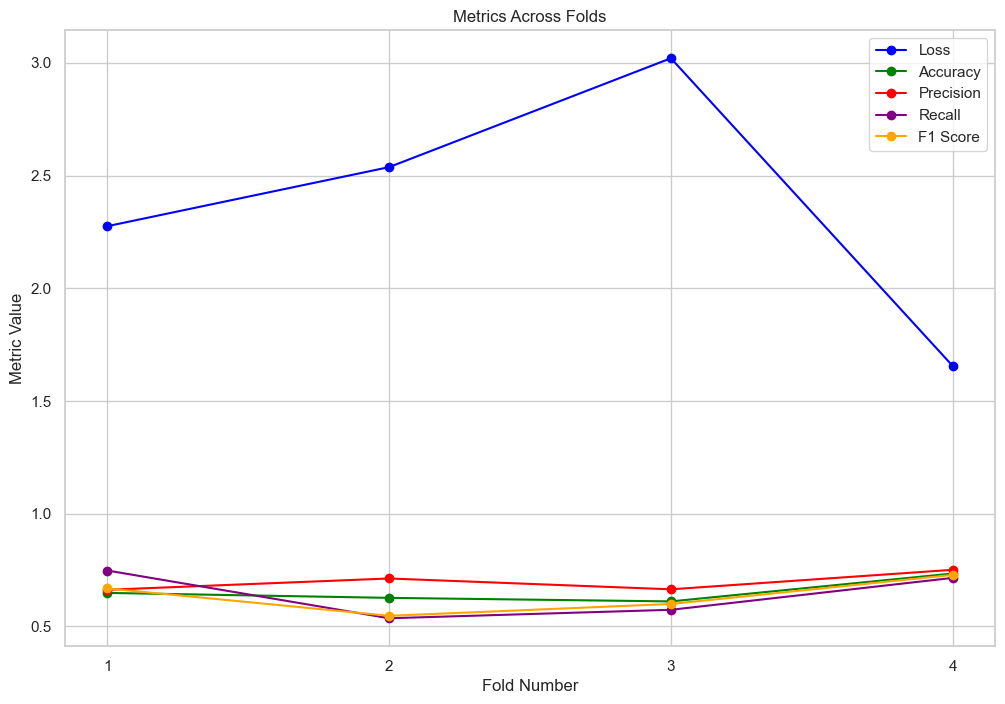

In [17]:
seed_1_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_1_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_1_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [18]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 720, Predictions: 720, Actuals: 720, Gender: 720


In [19]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [20]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.69 (76/110)


In [21]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
64,058A,"[senior, senior, senior]",senior,senior,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
73,067A,"[adult, adult, adult, kitten, adult, adult, ad...",adult,adult,True
71,065A,"[senior, adult, adult, adult, kitten, adult, a...",adult,adult,True
70,064A,[adult],adult,adult,True
69,063A,"[adult, adult, adult, adult, senior, adult, se...",adult,adult,True
68,062A,"[adult, adult, adult]",adult,adult,True


In [23]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  72.131148           61
1           kitten  73.333333           15
2           senior  61.764706           34


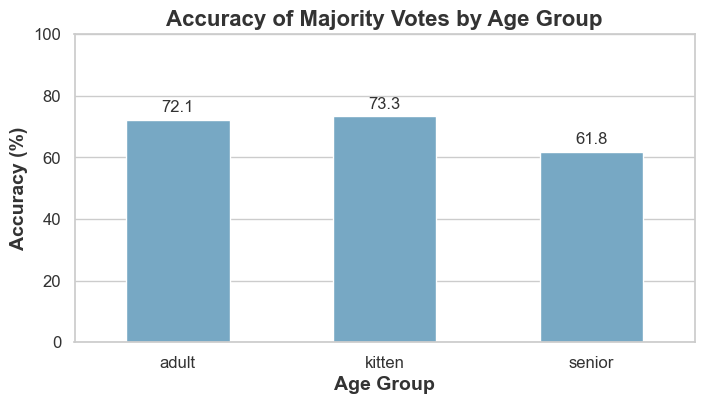

In [24]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [25]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  67.574932          367
1           kitten  59.000000          100
2           senior  63.636364          253


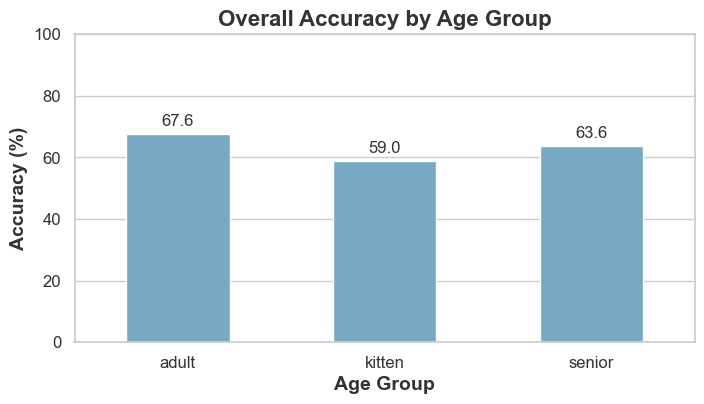

In [26]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [27]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      144     75.00
1          M    286      163     56.99
2          X    242      161     66.53


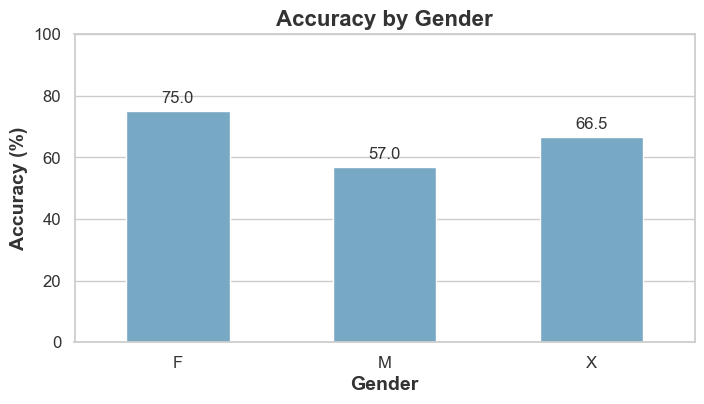

In [28]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [29]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  67.574932          367
1           kitten  59.000000          100
2           senior  63.636364          253]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    192      144     75.00
1          M    286      163     56.99
2          X    242      161     66.53]


# RANDOM SEED 2

In [30]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[1]))
np.random.seed(int(random_seeds[1]))
tf.random.set_seed(int(random_seeds[1]))

# Load datasets
dataframe = pd.read_csv('perch_looped_embeddings.csv')



def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     405
senior    253
kitten    135
Name: age_group, dtype: int64


In [31]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [32]:
tf.keras.backend.clear_session()

## Run Setup

In [33]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[1]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adam': Adam(learning_rate=0.007402414884293732)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(512, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.15688606637942396))  
    model_full.add(Dense(64, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.28869063762474007))  
    model_full.add(Dense(128, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27322054853254163))   
    model_full.add(Dense(32, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.4064145271744943))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adam']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
000A    39
103A    33
002B    30
020A    20
074A    16
097A    15
097B    14
002A    13
106A    13
101A    12
116A    12
055A    12
051A    12
111A    12
063A    11
059A    10
040A    10
025A    10
071A     9
016A     9
005A     9
051B     9
072A     9
033A     9
068A     8
031A     7
036A     7
117A     7
015A     7
095A     7
099A     6
039A     6
023A     6
075A     5
094A     5
070A     5
050A     5
108A     5
008A     5
109A     5
045A     4
003A     4
104A     4
026A     4
010A     3
012A     3
058A     3
060A     3
053A     3
006A     3
034A     3
062A     3
113A     3
105A     3
102A     2
061A     2
025B     2
011A     2
093A     2
035A     2
037A     2
038A     2
052A     2
087A     2
069A     2
054A     2
115A     1
100A     1
090A     1
110A     1
024A     1
043A     1
048A     1
019B     1
088A     1
066A     1
026C     1
092A     1
064A     1
026B     1
Name: cat_id, dtype: int64
Testing Set Group Distribution:
047A   

Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '002A' '002B' '003A' '005A' '006A' '008A' '010A' '011A' '012A'
 '015A' '016A' '019B' '020A' '023A' '024A' '025A' '025B' '026A' '026B'
 '026C' '031A' '033A' '034A' '035A' '036A' '037A' '038A' '039A' '040A'
 '043A' '045A' '046A' '048A' '050A' '051A' '051B' '052A' '053A' '054A'
 '055A' '058A' '059A' '060A' '061A' '062A' '063A' '064A' '066A' '068A'
 '069A' '070A' '071A' '072A' '074A' '075A' '087A' '088A' '090A' '092A'
 '093A' '094A' '095A' '097A' '097B' '099A' '100A' '101A' '102A' '103A'
 '104A' '105A' '106A' '108A' '109A' '110A' '111A' '113A' '115A' '116A'
 '117A']
AFTER SWAP - Unique Test Group IDs:
['000B' '001A' '004A' '007A' '009A' '013B' '014A' '014B' '018A' '019A'
 '021A' '022A' '023B' '025C' '027A' '028A' '029A' '032A' '041A' '042A'
 '044A' '047A' '049A' '056A' '057A' '065A' '067A' '073A' 

Moved to Training/Validation Set:
{'000A'}
Removed from Training/Validation Set:
{'003A'}
Moved to Test Set:
{'003A'}
Removed from Test Set
{'000A'}
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '004A' '006A' '007A' '008A' '009A' '011A' '013B'
 '014A' '014B' '015A' '016A' '018A' '019A' '019B' '020A' '021A' '022A'
 '023A' '023B' '024A' '025C' '026A' '026B' '026C' '027A' '028A' '029A'
 '032A' '033A' '034A' '035A' '036A' '037A' '038A' '039A' '040A' '041A'
 '042A' '043A' '044A' '046A' '047A' '048A' '049A' '050A' '051B' '052A'
 '055A' '056A' '057A' '060A' '061A' '062A' '064A' '065A' '066A' '067A'
 '068A' '070A' '072A' '073A' '074A' '075A' '076A' '088A' '091A' '093A'
 '094A' '096A' '100A' '101A' '102A' '104A' '105A' '106A' '108A' '109A'
 '111A' '113A' '115A' '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['002A' '002B' '003A' '005A' '010A' '012A' '025A' '025B' '031A' '045A'
 '051A' '053A' '054A' '058A' '059A' '063A' '069A' '071A' '087A' '090A'
 '092A' '095A' '0

Majority Vote Accuracy for cat_id for this fold: 0.70 (19/27)
Before appending - Cat IDs: 220, Predictions: 220, Actuals: 220, Gender: 220
After appending - Cat IDs: 437, Predictions: 437, Actuals: 437, Gender: 437
Final Test Results - Loss: 2.4907634258270264, Accuracy: 0.6497696042060852, Precision: 0.49484754803903735, Recall: 0.5061173533083646, F1 Score: 0.49967709885742667
Confusion Matrix:
 [[82  5 36]
 [ 4  1  0]
 [31  0 58]]
outer_fold 3
Train Set Group Distribution:
000A    39
103A    33
002B    30
047A    22
000B    19
019A    17
057A    17
029A    15
097A    15
097B    14
002A    13
055A    12
051A    12
111A    12
067A    11
063A    11
028A    11
042A    11
059A    10
025A    10
014B    10
072A     9
051B     9
065A     9
005A     9
071A     9
033A     9
022A     9
001A     9
068A     8
013B     8
036A     7
031A     7
015A     7
027A     7
095A     7
099A     6
023A     6
007A     6
021A     5
044A     5
025C     4
045A     4
026A     4
023B     4
009A     4
003A     4
01

Epoch 1/1500
22/22 [==============================] - 1s 4ms/step - loss: 0.9920 - accuracy: 0.5590
Epoch 2/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.5157 - accuracy: 0.7714
Epoch 3/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.3961 - accuracy: 0.8378
Epoch 4/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.3118 - accuracy: 0.8805
Epoch 5/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.2204 - accuracy: 0.9204
Epoch 6/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.1473 - accuracy: 0.9351
Epoch 7/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.9528
Epoch 8/1500
22/22 [==============================] - 0s 3ms/step - loss: 0.1520 - accuracy: 0.9395
Epoch 9/1500
22/22 [==============================] - 0s 4ms/step - loss: 0.1785 - accuracy: 0.9336
Epoch 10/1500
22/22 [==============================] - 0s 4ms/step - loss: 0.1098 - accuracy: 0.9587

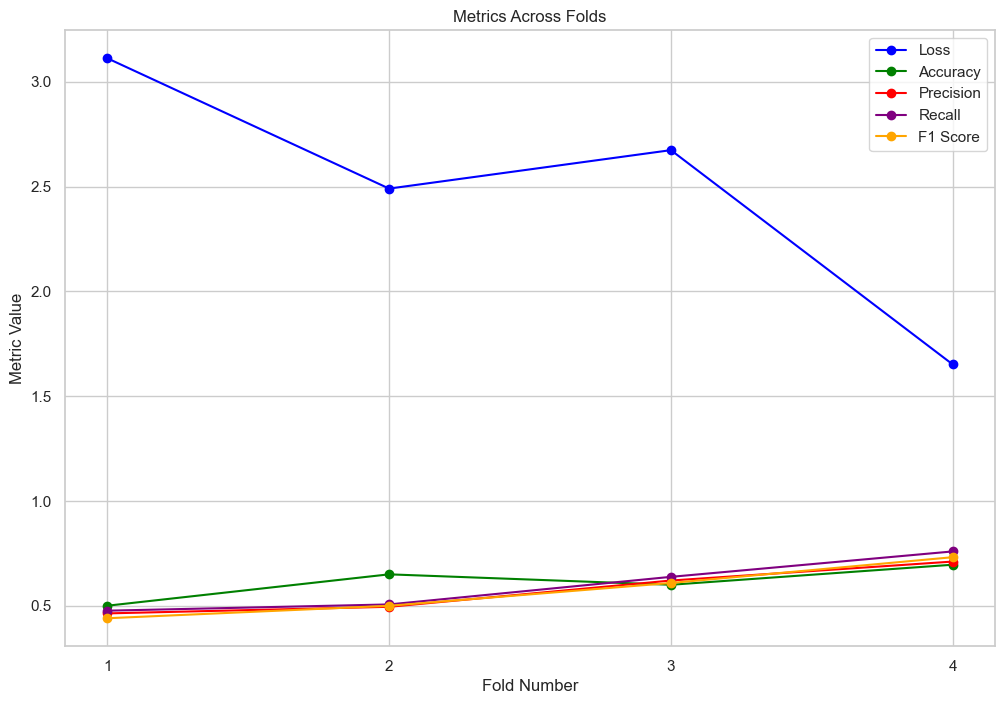

In [34]:
seed_2_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_2_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_2_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [35]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 717, Predictions: 717, Actuals: 717, Gender: 717


In [36]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [37]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.64 (70/110)


In [38]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [39]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
65,059A,"[senior, senior, senior, senior, senior, senio...",senior,senior,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[senior, adult, senior, adult, adult, senior, ...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
71,065A,"[senior, senior, adult, adult, kitten, senior,...",adult,adult,True
70,064A,[adult],adult,adult,True
69,063A,"[adult, kitten, adult, adult, adult, senior, a...",adult,adult,True
68,062A,"[adult, adult, adult]",adult,adult,True


In [40]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  68.852459           61
1           kitten  53.333333           15
2           senior  58.823529           34


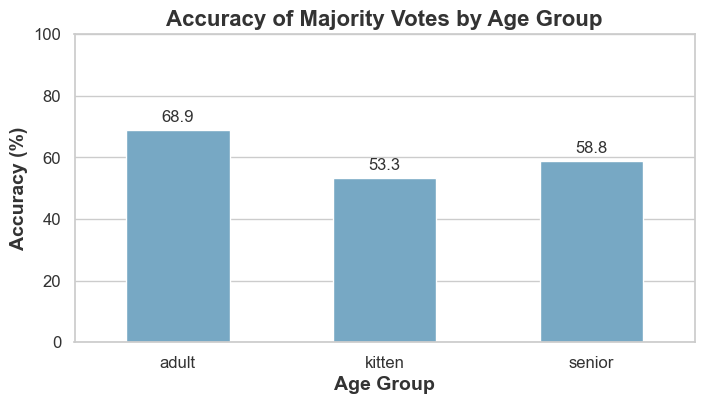

In [41]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [42]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  64.324324          370
1           kitten  44.680851           94
2           senior  59.288538          253


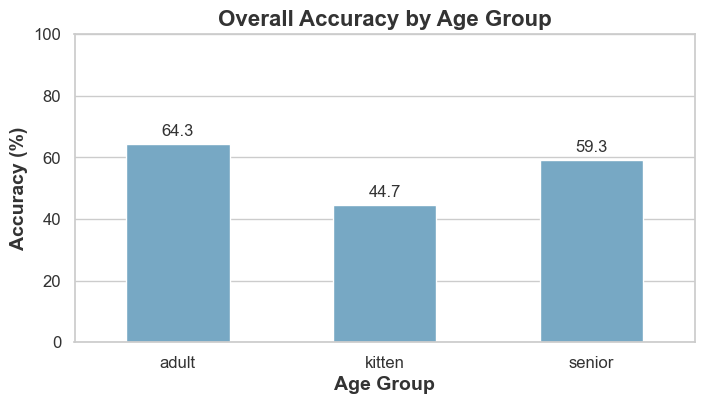

In [43]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [44]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      134     69.79
1          M    290      159     54.83
2          X    235      137     58.30


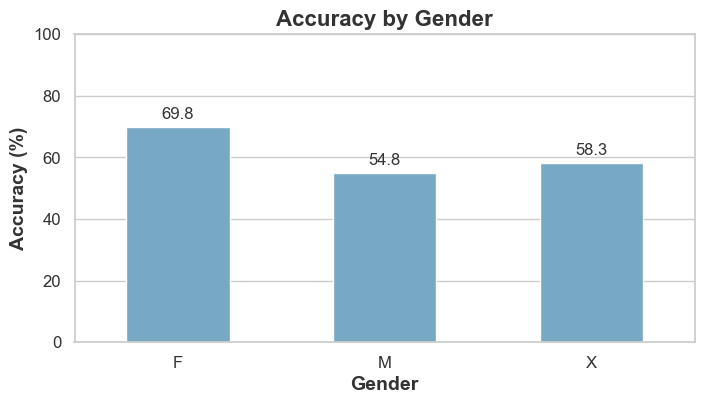

In [45]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [46]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.6363636363636364]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  67.574932          367
1           kitten  59.000000          100
2           senior  63.636364          253,   actual_age_group   accuracy  total_count
0            adult  64.324324          370
1           kitten  44.680851           94
2           senior  59.288538          253]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    192      144     75.00
1          M    286      163     56.99
2          X    242      161     66.53,   all_gender  count  correct  accuracy
0          F    192      134     69.79
1          M    290      159     54.83
2          X    235      137     58.30]


# RANDOM SEED 3

In [47]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[2]))
np.random.seed(int(random_seeds[2]))
tf.random.set_seed(int(random_seeds[2]))

# Load datasets
dataframe = pd.read_csv('perch_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     405
senior    253
kitten    135
Name: age_group, dtype: int64


In [48]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [49]:
tf.keras.backend.clear_session()

## Run Setup

In [50]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[2]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adam': Adam(learning_rate=0.007402414884293732)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(512, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.15688606637942396))  
    model_full.add(Dense(64, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.28869063762474007))  
    model_full.add(Dense(128, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27322054853254163))   
    model_full.add(Dense(32, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.4064145271744943))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adam']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
103A    33
047A    22
020A    20
000B    19
057A    17
019A    17
074A    16
029A    15
097A    15
097B    14
002A    13
055A    12
101A    12
116A    12
042A    11
028A    11
063A    11
040A    10
025A    10
059A    10
014B    10
071A     9
001A     9
051B     9
033A     9
013B     8
068A     8
036A     7
117A     7
031A     7
027A     7
015A     7
023A     6
039A     6
099A     6
044A     5
075A     5
050A     5
094A     5
008A     5
108A     5
109A     5
026A     4
003A     4
009A     4
104A     4
053A     3
012A     3
056A     3
058A     3
060A     3
006A     3
105A     3
014A     3
062A     3
034A     3
113A     3
011A     2
093A     2
037A     2
052A     2
038A     2
069A     2
032A     2
054A     2
061A     2
019B     1
110A     1
115A     1
100A     1
090A     1
024A     1
026C     1
004A     1
096A     1
092A     1
049A     1
064A     1
043A     1
076A     1
026B     1
Name: cat_id, dtype: int64
Testing Set Group Distributi

AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '003A' '004A' '006A' '008A' '009A' '011A'
 '012A' '013B' '014A' '014B' '015A' '019A' '019B' '020A' '023A' '024A'
 '025A' '026A' '026B' '026C' '027A' '028A' '029A' '031A' '032A' '033A'
 '034A' '036A' '037A' '038A' '039A' '040A' '042A' '043A' '044A' '046A'
 '047A' '049A' '050A' '051B' '052A' '053A' '054A' '055A' '056A' '057A'
 '058A' '059A' '060A' '061A' '062A' '063A' '064A' '068A' '069A' '071A'
 '074A' '075A' '076A' '090A' '092A' '093A' '094A' '096A' '097A' '097B'
 '099A' '100A' '101A' '103A' '104A' '108A' '109A' '110A' '113A' '115A'
 '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['002B' '005A' '007A' '010A' '016A' '018A' '021A' '022A' '023B' '025B'
 '025C' '035A' '041A' '045A' '048A' '051A' '065A' '066A' '067A' '070A'
 '072A' '073A' '087A' '088A' '091A' '095A' '102A' '105A' '106A' '111A']
Length of X_train_val:
613
Length of y_train_val:
613
Length of groups_train_val:
613
No common groups found betwee

AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '002A' '002B' '004A' '005A' '007A' '008A' '009A' '010A' '011A'
 '012A' '013B' '014B' '015A' '016A' '018A' '019A' '019B' '021A' '022A'
 '023A' '023B' '025B' '025C' '026A' '026B' '027A' '031A' '032A' '033A'
 '035A' '036A' '037A' '038A' '040A' '041A' '043A' '045A' '046A' '048A'
 '049A' '050A' '051A' '051B' '053A' '054A' '055A' '056A' '057A' '058A'
 '059A' '060A' '061A' '062A' '063A' '065A' '066A' '067A' '069A' '070A'
 '071A' '072A' '073A' '074A' '075A' '076A' '087A' '088A' '091A' '092A'
 '094A' '095A' '096A' '097B' '099A' '100A' '101A' '102A' '103A' '105A'
 '106A' '110A' '111A' '113A' '115A']
AFTER SWAP - Unique Test Group IDs:
['000B' '001A' '003A' '006A' '014A' '020A' '024A' '025A' '026C' '028A'
 '029A' '034A' '039A' '042A' '044A' '047A' '052A' '064A' '068A' '090A'
 '093A' '097A' '104A' '108A' '109A' '116A' '117A']
Length of X_train_val:
588
Length of y_train_val:
588
Length of groups_train_val:
588
No common groups found betwee

Age group distribution: Counter({0: 328, 2: 132, 1: 122})
Epoch 1/1500
19/19 [==============================] - 1s 3ms/step - loss: 1.0954 - accuracy: 0.5017
Epoch 2/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6856
Epoch 3/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.4133 - accuracy: 0.8127
Epoch 4/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.2792 - accuracy: 0.8729
Epoch 5/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.2397 - accuracy: 0.8952
Epoch 6/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.1466 - accuracy: 0.9364
Epoch 7/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1364 - accuracy: 0.9605
Epoch 8/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.1511 - accuracy: 0.9485
Epoch 9/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9502
Epoch 10/1500
19/19 [=====================

Majority Vote Accuracy for cat_id for this fold: 0.69 (20/29)
Before appending - Cat IDs: 385, Predictions: 385, Actuals: 385, Gender: 385
After appending - Cat IDs: 596, Predictions: 596, Actuals: 596, Gender: 596
Final Test Results - Loss: 1.7446887493133545, Accuracy: 0.6824644804000854, Precision: 0.7566760037348272, Recall: 0.7965367965367965, F1 Score: 0.7528344671201813
Confusion Matrix:
 [[65  1 11]
 [ 0 13  0]
 [54  1 66]]
outer_fold 4
Train Set Group Distribution:
046A    45
000A    39
103A    33
002B    30
047A    22
020A    20
000B    19
057A    17
019A    17
097A    15
029A    15
106A    13
002A    13
116A    12
111A    12
051A    12
101A    12
055A    12
028A    11
067A    11
042A    11
063A    11
040A    10
025A    10
059A    10
051B     9
016A     9
065A     9
001A     9
071A     9
072A     9
005A     9
022A     9
013B     8
068A     8
095A     7
117A     7
015A     7
027A     7
023A     6
039A     6
007A     6
108A     5
094A     5
070A     5
044A     5
008A     5
021A

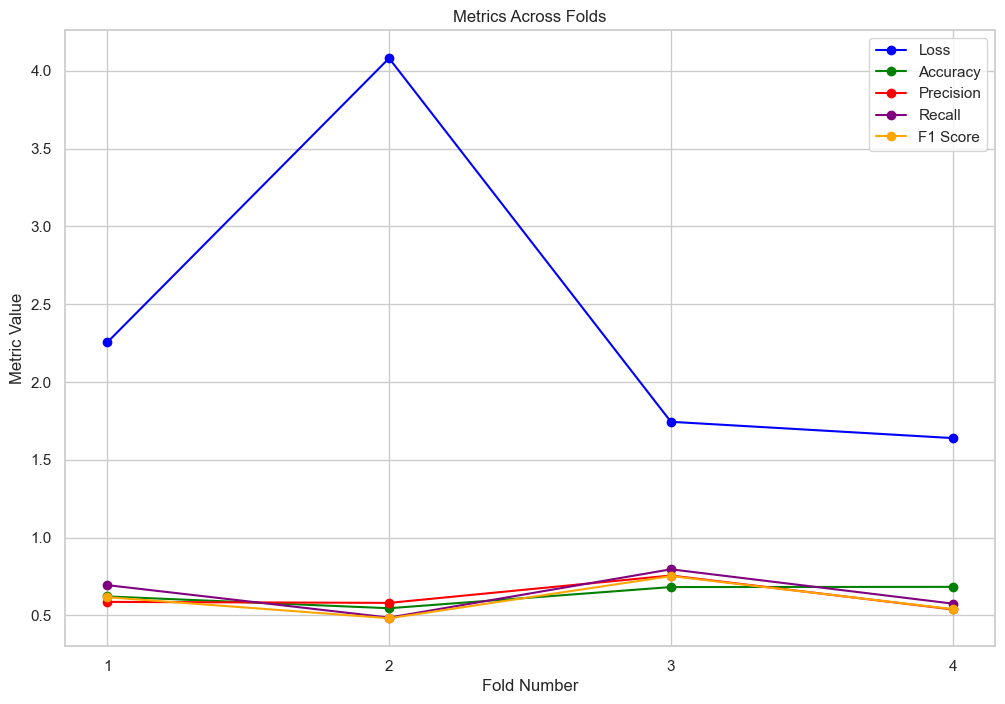

In [51]:
seed_3_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_3_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_3_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [52]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 713, Predictions: 713, Actuals: 713, Gender: 713


In [53]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [54]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.68 (75/110)


In [55]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [56]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, kitten, adult, a...",adult,adult,True
46,040A,"[kitten, kitten, kitten, kitten, kitten, kitte...",kitten,kitten,True
77,071A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, kit...",adult,adult,True
71,065A,"[senior, senior, adult, adult, kitten, senior,...",adult,adult,True
70,064A,[adult],adult,adult,True
69,063A,"[adult, adult, adult, adult, adult, senior, ad...",adult,adult,True
68,062A,"[adult, adult, adult]",adult,adult,True
65,059A,"[senior, kitten, senior, senior, senior, senio...",senior,senior,True


In [57]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  72.131148           61
1           kitten  80.000000           15
2           senior  55.882353           34


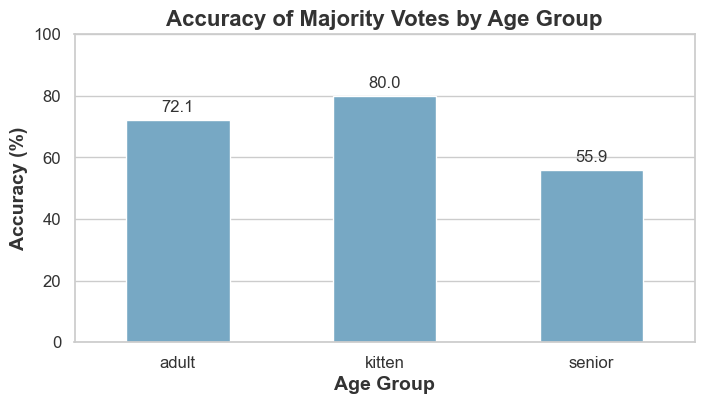

In [58]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [59]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  68.834688          369
1           kitten  53.846154           91
2           senior  57.312253          253


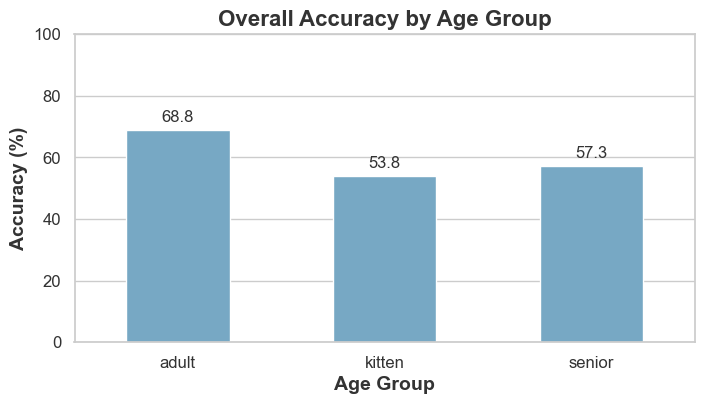

In [60]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [61]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      125     65.10
1          M    289      171     59.17
2          X    232      152     65.52


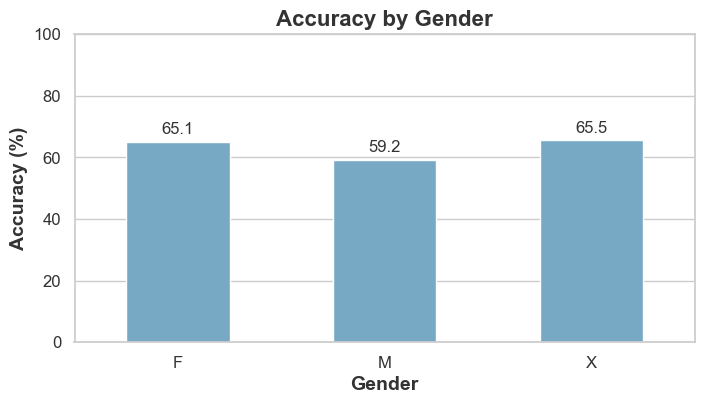

In [62]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [63]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.6363636363636364, 0.6818181818181818]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  67.574932          367
1           kitten  59.000000          100
2           senior  63.636364          253,   actual_age_group   accuracy  total_count
0            adult  64.324324          370
1           kitten  44.680851           94
2           senior  59.288538          253,   actual_age_group   accuracy  total_count
0            adult  68.834688          369
1           kitten  53.846154           91
2           senior  57.312253          253]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    192      144     75.00
1          M    286      163     56.99
2          X    242      161     66.53,   all_gender  count  correct  accuracy
0          F    192      134     69.79
1          M    290      159     54.83
2          X    235      137     58.30,   al

# RANDOM SEED 4

In [64]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[3])) 
np.random.seed(int(random_seeds[3]))
tf.random.set_seed(int(random_seeds[3]))

# Load datasets
dataframe = pd.read_csv('perch_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     405
senior    253
kitten    135
Name: age_group, dtype: int64


In [65]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [66]:
tf.keras.backend.clear_session()

## Run Setup

In [67]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[3]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adam': Adam(learning_rate=0.007402414884293732)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(512, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.15688606637942396))  
    model_full.add(Dense(64, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.28869063762474007))  
    model_full.add(Dense(128, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27322054853254163))   
    model_full.add(Dense(32, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.4064145271744943))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adam']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)
        


outer_fold 1
Train Set Group Distribution:
046A    45
103A    33
002B    30
047A    22
000B    19
019A    17
057A    17
074A    16
097A    15
029A    15
106A    13
055A    12
101A    12
116A    12
111A    12
042A    11
028A    11
063A    11
059A    10
014B    10
040A    10
001A     9
022A     9
051B     9
033A     9
005A     9
071A     9
072A     9
016A     9
013B     8
068A     8
027A     7
036A     7
031A     7
015A     7
095A     7
039A     6
099A     6
008A     5
094A     5
075A     5
050A     5
021A     5
108A     5
109A     5
070A     5
003A     4
026A     4
025C     4
045A     4
009A     4
023B     4
060A     3
056A     3
034A     3
014A     3
105A     3
069A     2
018A     2
102A     2
061A     2
032A     2
052A     2
011A     2
038A     2
090A     1
048A     1
100A     1
110A     1
115A     1
088A     1
076A     1
066A     1
026C     1
041A     1
092A     1
049A     1
096A     1
091A     1
064A     1
073A     1
026B     1
Name: cat_id, dtype: int64
Testing Set Group Distributi

Train Age Group Distribution BEFORE SWAP:
adult     265
senior    206
kitten    129
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
adult     140
senior     47
kitten      6
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     285
senior    206
kitten    129
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     120
senior     47
kitten      6
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 285, 2: 206, 1: 129})
Epoch 1/1500
20/20 [==============================] - 1s 4ms/step - loss: 1.0691 - accuracy: 0.5371
Epoch 2/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.4874 - accuracy: 0.7871
Epoch 3/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.3488 - accuracy: 0.8629
Epoch 4/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.1944 - accuracy: 0.9258
Epoch 5/1500
20/20 [================

Train Age Group Distribution BEFORE SWAP:
adult     350
senior    201
kitten     49
Name: age_group, dtype: int64
Testing Set Age Group Distribution BEFORE SWAP:
kitten    86
adult     55
senior    52
Name: age_group, dtype: int64
Train Age Group Distribution AFTER SWAP:
adult     350
senior    201
kitten     89
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     55
senior    52
kitten    46
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 350, 2: 201, 1: 89})
Epoch 1/1500
20/20 [==============================] - 1s 3ms/step - loss: 0.8857 - accuracy: 0.5422
Epoch 2/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.4642 - accuracy: 0.7891
Epoch 3/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.2686 - accuracy: 0.8859
Epoch 4/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.2446 - accuracy: 0.8984
Epoch 5/1500
20/20 [=======================


Moved to Training/Validation Set:
set()
Removed from Training/Validation Set:
set()
Moved to Test Set:
set()
Removed from Test Set
set()
AFTER SWAP - Unique Training/Validation Group IDs:
['000A' '000B' '001A' '002A' '004A' '005A' '006A' '007A' '008A' '009A'
 '010A' '012A' '014A' '014B' '015A' '016A' '018A' '019B' '020A' '022A'
 '023A' '023B' '024A' '025A' '025B' '025C' '026A' '026B' '026C' '028A'
 '029A' '034A' '035A' '036A' '037A' '038A' '040A' '043A' '044A' '045A'
 '046A' '047A' '048A' '049A' '050A' '051A' '051B' '052A' '053A' '054A'
 '055A' '056A' '058A' '060A' '061A' '062A' '063A' '065A' '066A' '067A'
 '068A' '069A' '072A' '074A' '075A' '076A' '087A' '088A' '090A' '093A'
 '094A' '096A' '097B' '099A' '104A' '105A' '106A' '108A' '110A' '113A'
 '115A' '116A' '117A']
AFTER SWAP - Unique Test Group IDs:
['002B' '003A' '011A' '013B' '019A' '021A' '027A' '031A' '032A' '033A'
 '039A' '041A' '042A' '057A' '059A' '064A' '070A' '071A' '073A' '091A'
 '092A' '095A' '097A' '100A' '101A' '102A'

Train Age Group Distribution AFTER SWAP:
adult     311
senior    195
kitten    121
Name: age_group, dtype: int64
Testing Set Age Group Distribution AFTER SWAP:
adult     94
senior    58
kitten    14
Name: age_group, dtype: int64

 Starting training on unseen test set

Age group distribution: Counter({0: 311, 2: 195, 1: 121})
Epoch 1/1500
20/20 [==============================] - 1s 4ms/step - loss: 0.9573 - accuracy: 0.5869
Epoch 2/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.4426 - accuracy: 0.8006
Epoch 3/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.3256 - accuracy: 0.8820
Epoch 4/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.2174 - accuracy: 0.9203
Epoch 5/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.2089 - accuracy: 0.9187
Epoch 6/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9426
Epoch 7/1500
20/20 [==============================] - 0s 3ms/step - loss:

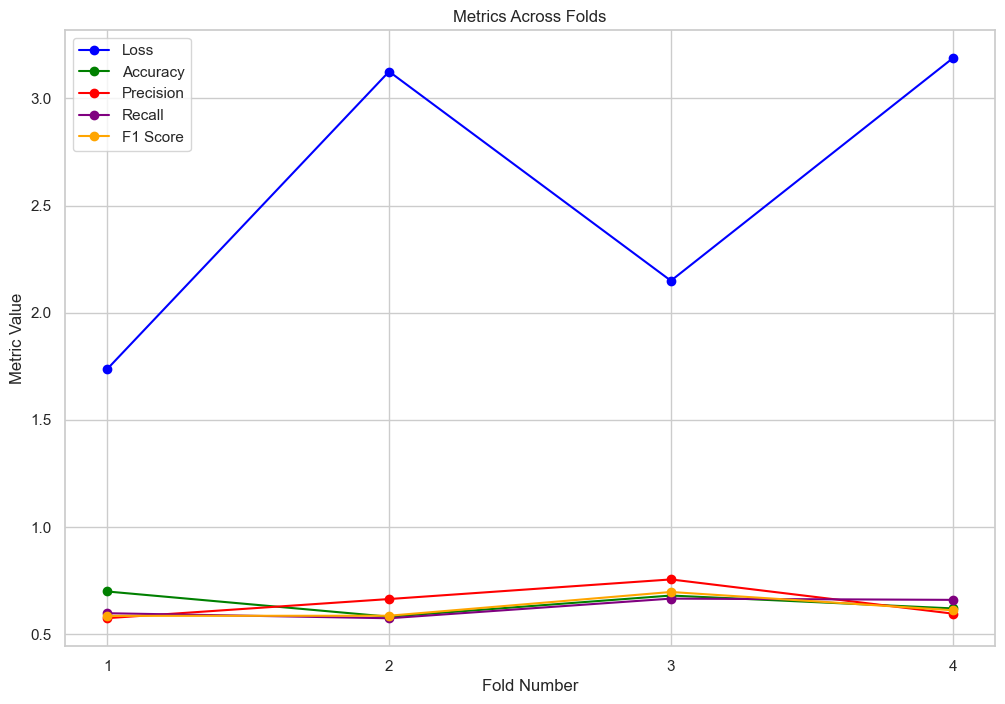

In [68]:
seed_4_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_4_training_acc_values = cv_training_acc_total

# Plotting all fold metrics
seed_4_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [69]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 733, Predictions: 733, Actuals: 733, Gender: 733


In [70]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [71]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.68 (75/110)


In [72]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [73]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
65,059A,"[senior, senior, senior, adult, senior, senior...",senior,senior,True
78,072A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
77,071A,"[adult, adult, adult, senior, adult, senior, a...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[kitten, senior, adult, adult, adult, adult, a...",adult,adult,True
73,067A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
71,065A,"[senior, senior, adult, adult, kitten, adult, ...",adult,adult,True
70,064A,[adult],adult,adult,True
69,063A,"[adult, adult, adult, adult, senior, adult, ad...",adult,adult,True


In [74]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  72.131148           61
1           kitten  86.666667           15
2           senior  52.941176           34


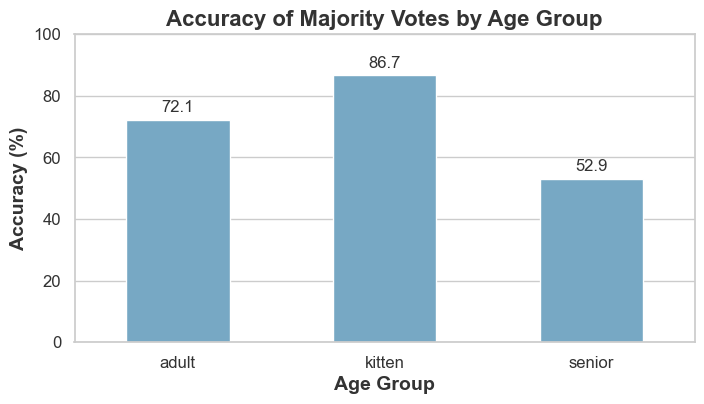

In [75]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


## Detailed Class Statistics

In [76]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  72.467532          385
1           kitten  56.842105           95
2           senior  56.916996          253


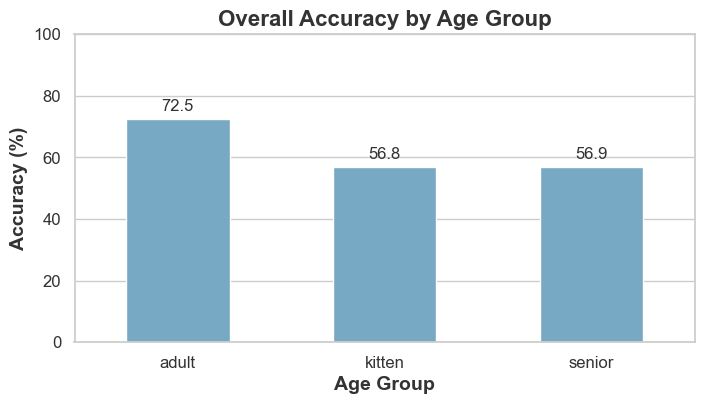

In [77]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [78]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    211      156     73.93
1          M    286      164     57.34
2          X    236      157     66.53


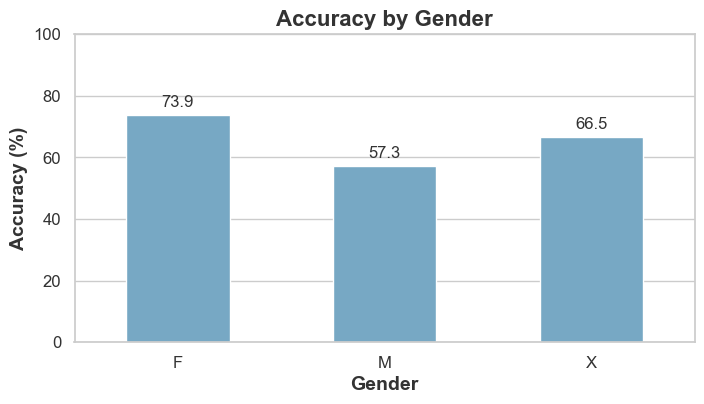

In [79]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [80]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats)
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.6363636363636364, 0.6818181818181818, 0.6818181818181818]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  67.574932          367
1           kitten  59.000000          100
2           senior  63.636364          253,   actual_age_group   accuracy  total_count
0            adult  64.324324          370
1           kitten  44.680851           94
2           senior  59.288538          253,   actual_age_group   accuracy  total_count
0            adult  68.834688          369
1           kitten  53.846154           91
2           senior  57.312253          253,   actual_age_group   accuracy  total_count
0            adult  72.467532          385
1           kitten  56.842105           95
2           senior  56.916996          253]
Total Gender Accuracy so far:
 [  all_gender  count  correct  accuracy
0          F    192      144     75.00
1          M    286      163     56.99
2       

# RANDOM SEED 5

In [81]:
# Set a fixed random seed for reproducibility
random.seed(int(random_seeds[4]))
np.random.seed(int(random_seeds[4]))
tf.random.set_seed(int(random_seeds[4]))

# Load datasets
dataframe = pd.read_csv('perch_looped_embeddings.csv')


def assign_age_group(age, age_groups):
    for group_name, age_range in age_groups.items():
        if age_range[0] <= age < age_range[1]:
            return group_name
    return 'Unknown'  # For any age that doesn't fit the defined groups

# Define age groups
age_groups = {
    'kitten': (0, 0.5),
    'adult': (0.5, 10),
    'senior': (10, 20)
}

# Create a new column for the age group
dataframe['age_group'] = dataframe['target'].apply(assign_age_group, age_groups=age_groups)

print(dataframe['age_group'].value_counts())

adult     405
senior    253
kitten    135
Name: age_group, dtype: int64


In [82]:
# Separate features and labels
X = dataframe.iloc[:, :-4].values  # all columns except the last four

# Encode the 'age_group' column as integers using LabelEncoder
label_encoder = LabelEncoder()
encoded_y = label_encoder.fit_transform(dataframe['age_group'].values)

# Use the encoded labels for splitting and one-hot encoding
y = encoded_y  

# Convert 'cat_id' column to numpy array to be used as groups array for GroupKFold
groups = dataframe['cat_id'].values

In [83]:
tf.keras.backend.clear_session()

## Run Setup

In [84]:
all_cat_ids = []
all_predicted_age_groups = []
all_actual_age_groups = []
all_gender = []

# Define the StratifiedGroupKFold splitter for 4 fold CV with random shuffling
outer_cv = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=int(random_seeds[4]))

# unseen test set metrics
unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1 = [], [], [], [], []

cv_training_acc_total = []
cv_training_acc_best = []

outer_fold = 0

# Use the splitter to generate indices for training and testing sets
# Note: GroupShuffleSplit.split returns indices, so we use it to index the arrays
for train_val_idx, test_idx in outer_cv.split(X, y, groups):
    outer_fold += 1
    logger(f"outer_fold {outer_fold}", file=log_file_path)

    # Convert indices back to DataFrame for easy manipulation
    df_train_val = dataframe.iloc[train_val_idx]
    df_test = dataframe.iloc[test_idx]

    ##############################
    # ASSESSING SPLITS BY CAT_ID #
    ##############################
    
    # Get the distribution of groups
    training_validation_group_distribution = df_train_val['cat_id'].value_counts()  
    testing_group_distribution = df_test['cat_id'].value_counts()  
    
    # Log or print the distribution
    logger(f"Train Set Group Distribution:\n{training_validation_group_distribution}", file=log_file_path)
    logger(f"Testing Set Group Distribution:\n{testing_group_distribution}", file=log_file_path)

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val['gender'].value_counts()
    testing_gender_distribution = df_test['gender'].value_counts()
    
    # Log the distribution
    logger(f"Training Set Gender Distribution BEFORE SWAP:\n{training_gender_distribution}", file=log_file_path)
    logger(f"Testing Set Gender Distribution BEFORE SWAP:\n{testing_gender_distribution}", file=log_file_path)

    # Group by 'age_group' and then list unique 'cat_id' within each age group
    unique_cat_ids_per_age_group_train_val = df_train_val.groupby('age_group')['cat_id'].unique()
    unique_cat_ids_per_age_group_test = df_test.groupby('age_group')['cat_id'].unique()
    
    # Log results
    logger(f"Unique Cat IDs per Age Group in Training/Validation Set:\n{unique_cat_ids_per_age_group_train_val}", file=log_file_path)
    logger(f"Unique Cat IDs per Age Group in Testing Set:\n{unique_cat_ids_per_age_group_test}", file=log_file_path)

    # Calculate the count of unique identifiers per age group for training and testing set
    counts_train_val = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_train_val.items()}
    counts_test = {age_group: len(identifiers) for age_group, identifiers in unique_cat_ids_per_age_group_test.items()}

    # Log the counts of unique identifiers per age group
    logger(f"Count of Unique Cat IDs per Age Group in Training/Validation Set:\n{counts_train_val}", file=log_file_path)
    logger(f"Count of Unique Cat IDs per Age Group in Testing Set:\n{counts_test}", file=log_file_path)

    #######################################################
    # CONTINUE WITH ENSURING VALID AND APPROPRIATE SPLITS #
    #######################################################
    
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    groups_train_val, groups_test = groups[train_val_idx], groups[test_idx]

    # logging identifier splits 
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)

    # check group splits
    check_initial_group_split(groups_train_val, groups_test)

    # Specify the cat_ids that must be in the training/validation set
    specific_cat_ids = ['000A', '046A']
    
    # Perform the swapping operation
    train_val_idx, test_idx = swap_cat_id_instances(dataframe, train_val_idx, test_idx, specific_cat_ids)
    
    # Re-assign the sets based on the updated indices
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    new_groups_train_val, new_groups_test = groups[train_val_idx], groups[test_idx]

    # Find differences for training and test sets
    moved_to_train_val, removed_from_train_val = find_group_differences(groups_train_val, new_groups_train_val)
    moved_to_test, removed_from_test = find_group_differences(groups_test, new_groups_test)
    
    # Display the results
    logger(f"Moved to Training/Validation Set:\n{moved_to_train_val}", file=log_file_path)
    logger(f"Removed from Training/Validation Set:\n{removed_from_train_val}", file=log_file_path)
    logger(f"Moved to Test Set:\n{moved_to_test}", file=log_file_path)
    logger(f"Removed from Test Set\n{removed_from_test}", file=log_file_path)

    # Update X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test based on updated indices
    X_train_val = X[train_val_idx]
    y_train_val = y[train_val_idx]
    groups_train_val = groups[train_val_idx]
    
    X_test = X[test_idx]
    y_test = y[test_idx]
    groups_test = groups[test_idx]

    # logging identifier splits again after potential swaps
    unique_train_val_groups = np.unique(groups_train_val)
    unique_test_groups = np.unique(groups_test)
    
    logger(f"AFTER SWAP - Unique Training/Validation Group IDs:\n{unique_train_val_groups}", file=log_file_path)
    logger(f"AFTER SWAP - Unique Test Group IDs:\n{unique_test_groups}", file=log_file_path)
    
    # Verify the lengths are consistent
    logger(f"Length of X_train_val:\n{len(X_train_val)}", file=log_file_path)
    logger(f"Length of y_train_val:\n{len(y_train_val)}", file=log_file_path)
    logger(f"Length of groups_train_val:\n{len(groups_train_val)}", file=log_file_path)

    # Check group splits once more
    check_initial_group_split(groups_train_val, groups_test)

    # Convert the modified indices back to a DataFrame representing the updated df_train_val
    df_train_val_updated = dataframe.iloc[train_val_idx].copy()
    df_test_updated = dataframe.iloc[test_idx].copy()

    ############################
    # LOGGING AGE GROUP SPLITS #
    ############################

    # Get the distribution of age groups of age groups before the update
    training_validation_age_group_distribution = df_train_val['age_group'].value_counts()
    testing_age_group_distribution = df_test['age_group'].value_counts()
    
    # Logthe distribution
    logger(f"Train Age Group Distribution BEFORE SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution BEFORE SWAP:\n{testing_age_group_distribution}", file=log_file_path)

    # Get the distribution of age groups after the update
    training_validation_age_group_distribution = df_train_val_updated['age_group'].value_counts()
    testing_age_group_distribution = df_test_updated['age_group'].value_counts()
    
    # Log the distribution
    logger(f"Train Age Group Distribution AFTER SWAP:\n{training_validation_age_group_distribution}", file=log_file_path)
    logger(f"Testing Set Age Group Distribution AFTER SWAP:\n{testing_age_group_distribution}", file=log_file_path)
    
    ########################################################
    # TRACKING FINAL CAT_IDs & GENDER AFTER REDISTRIBUTION #
    ########################################################

    # Get the distribution of groups
    training_validation_group_distribution = df_train_val_updated['cat_id'].value_counts()  
    testing_group_distribution = df_test_updated['cat_id'].value_counts()  

    # Log gender distribution in training and testing datasets
    training_gender_distribution = df_train_val_updated['gender'].value_counts()
    testing_gender_distribution = df_test_updated['gender'].value_counts()
    
    logger(f"\n Starting training on unseen test set\n", file=log_file_path)

    ###################
    # PREPARING MODEL #
    ###################

    # Calculate the distribution of age groups in y_train_val
    age_group_distribution = Counter(y_train_val)
    print("Age group distribution:", age_group_distribution)

    # EarlyStopping callback: monitor 'loss' instead of 'val_loss' for the test set
    early_stopping = EarlyStopping(
        monitor='loss',  
        min_delta=0.001, 
        patience=30,  
        verbose=1,  
        restore_best_weights=True  
    )
    
    accuracy_history = AccuracyHistory()

    # One final shuffle to ensure randomness
    outer_shuffle_idx = np.random.permutation(len(X_train_val))
    X_train_val = X_train_val[outer_shuffle_idx]
    y_train_val = y_train_val[outer_shuffle_idx]
    
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train_val),
        y=y_train_val
    )
    weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Scale the features
    scaler_full = StandardScaler().fit(X_train_val)
    X_train_full_scaled = scaler_full.transform(X_train_val)
    X_test_scaled = scaler_full.transform(X_test)
    
    # Encode the labels
    y_train_full_encoded = to_categorical(y_train_val)
    y_test_encoded = to_categorical(y_test)

    #######################
    # BUILD & TRAIN MODEL #
    #######################

    optimizers = {
        'Adam': Adam(learning_rate=0.007402414884293732)
    }
    
    # Full model definition with dynamic number of layers
    model_full = Sequential()
    model_full.add(Dense(512, activation='relu', input_shape=(X_train_full_scaled.shape[1],)))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.15688606637942396))  
    model_full.add(Dense(64, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.28869063762474007))  
    model_full.add(Dense(128, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.27322054853254163))   
    model_full.add(Dense(32, activation='relu'))  
    model_full.add(BatchNormalization())
    model_full.add(Dropout(0.4064145271744943))  
    model_full.add(Dense(3, activation='softmax'))  
    
    optimizer = optimizers['Adam']  # optimizer_key from parameters
    
    # Compile the model
    model_full.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model on the full training set
    history_full = model_full.fit(X_train_full_scaled, y_train_full_encoded, epochs=1500, batch_size=32,
                                  verbose=1, callbacks=[early_stopping, accuracy_history], class_weight=weight_dict)
    
    
    # log epochs
    best_epoch_index = np.argmin(history_full.history['loss'])  
    best_training_accuracy = accuracy_history.acc[best_epoch_index]

    # Append training acc to total  
    all_best_training_acc.append(best_training_accuracy)
    total_training_acc.append(accuracy_history.acc)

    # Append training acc just for this CV
    cv_training_acc_total.append(accuracy_history.acc)
    cv_training_acc_best.append(best_training_accuracy)
    
    # Evaluate the model on the held-out test set
    test_loss, test_accuracy = model_full.evaluate(X_test_scaled, y_test_encoded)

    y_test_pred_prob = model_full.predict(X_test_scaled)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)  
    y_test_true = np.argmax(y_test_encoded, axis=1)    

    ################################
    # LOG MAJORITY VOTE PER CAT_ID #
    ################################

    # Convert numeric predictions back to age group labels
    predicted_age_groups = label_encoder.inverse_transform(y_test_pred)
    actual_labels = label_encoder.inverse_transform(y_test_true)
    
    # Map predictions and actual labels back to cat_ids
    test_results = pd.DataFrame({
        'cat_id': df_test_updated['cat_id'],
        'predicted_age_group': predicted_age_groups,
        'actual_age_group': actual_labels
    })
    
    # Group by cat_id and aggregate predicted age groups
    majority_votes = test_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
    actual_groups = test_results.groupby('cat_id')['actual_age_group'].first()
    
    # Calculate the accuracy of majority voting
    correct_predictions = (majority_votes == actual_groups).sum()
    total_cats = len(actual_groups)
    majority_vote_accuracy = correct_predictions / total_cats
    
    # Log the accuracy of the majority voting
    logger(f"Majority Vote Accuracy for cat_id for this fold: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

    ####################################################
    # COLLECT PREDICTIONS FOR GENDER & CAT_ID ANALYSIS #
    ####################################################

    # Debugging print statements
    print(f'Before appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Extend lists with current fold results
    all_cat_ids.extend(df_test_updated['cat_id'].tolist())
    all_predicted_age_groups.extend(predicted_age_groups)
    all_actual_age_groups.extend(actual_labels)
    all_gender.extend(df_test_updated['gender'].tolist())

    # Debugging print statements
    print(f'After appending - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')
    
    # Calculate additional metrics
    test_precision = precision_score(y_test_true, y_test_pred, average='macro')  # Use 'macro' for imbalanced datasets
    test_recall = recall_score(y_test_true, y_test_pred, average='macro')
    test_f1 = f1_score(y_test_true, y_test_pred, average='macro')

    # prepare averages of outer metrics
    unseen_f1.append(test_f1)
    unseen_losses.append(test_loss)
    unseen_accuracies.append(test_accuracy)
    unseen_precisions.append(test_precision)
    unseen_recalls.append(test_recall)

    # Print final test results
    logger(f"Final Test Results - Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, F1 Score: {test_f1}", file=log_file_path)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    logger(f"Confusion Matrix:\n {cm}", file=log_file_path)

# Calculate the overall average metrics
unseen_set_avg_f1 = np.mean(unseen_f1)
unseen_set_avg_loss = np.mean(unseen_losses)
unseen_set_avg_acc = np.mean(unseen_accuracies)
unseen_set_avg_precision = np.mean(unseen_precisions)
unseen_set_avg_recall = np.mean(unseen_recalls)

logger(f"\nFinal Average F1-Score across all UNSEEN TEST sets: {unseen_set_avg_f1}", file=log_file_path)
logger(f"\nFinal Average Loss across all UNSEEN TEST sets: {unseen_set_avg_loss}", file=log_file_path)
logger(f"\nFinal Average Accuracy across all UNSEEN TEST sets: {unseen_set_avg_acc}", file=log_file_path)
logger(f"\nFinal Average Precision across all UNSEEN TEST sets: {unseen_set_avg_precision}", file=log_file_path)
logger(f"\nFinal Average Recall across all UNSEEN TEST sets: {unseen_set_avg_recall}\n", file=log_file_path)

# Append averages to total lists
average_fold_f1.append(unseen_set_avg_f1)
average_fold_losses.append(unseen_set_avg_loss)
average_fold_accuracies.append(unseen_set_avg_acc)
average_fold_precisions.append(unseen_set_avg_precision)
average_fold_recalls.append(unseen_set_avg_recall)

# Append all to total lists
all_f1.append(unseen_f1)
all_losses.append(unseen_losses)
all_accuracies.append(unseen_accuracies)
all_precisions.append(unseen_precisions)
all_recalls.append(unseen_recalls)

outer_fold 1
Train Set Group Distribution:
046A    45
103A    33
002B    30
047A    22
000B    19
057A    17
097A    15
106A    13
002A    13
055A    12
101A    12
111A    12
051A    12
063A    11
067A    11
028A    11
014B    10
025A    10
059A    10
040A    10
071A     9
051B     9
065A     9
016A     9
072A     9
033A     9
001A     9
068A     8
013B     8
036A     7
117A     7
031A     7
095A     7
027A     7
099A     6
023A     6
044A     5
075A     5
050A     5
109A     5
025C     4
104A     4
009A     4
026A     4
023B     4
056A     3
105A     3
012A     3
010A     3
058A     3
006A     3
034A     3
113A     3
014A     3
062A     3
018A     2
093A     2
102A     2
061A     2
011A     2
035A     2
052A     2
038A     2
069A     2
087A     2
049A     1
024A     1
090A     1
100A     1
076A     1
115A     1
088A     1
043A     1
048A     1
066A     1
073A     1
064A     1
026C     1
096A     1
041A     1
092A     1
026B     1
Name: cat_id, dtype: int64
Testing Set Group Distributi

Epoch 1/1500
19/19 [==============================] - 1s 4ms/step - loss: 1.0145 - accuracy: 0.5526
Epoch 2/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.4308 - accuracy: 0.8147
Epoch 3/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.2644 - accuracy: 0.8965
Epoch 4/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.2036 - accuracy: 0.9282
Epoch 5/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1246 - accuracy: 0.9533
Epoch 6/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1083 - accuracy: 0.9649
Epoch 7/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1052 - accuracy: 0.9666
Epoch 8/1500
19/19 [==============================] - 0s 5ms/step - loss: 0.0582 - accuracy: 0.9800
Epoch 9/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.0273 - accuracy: 0.9967
Epoch 10/1500
19/19 [==============================] - 0s 5ms/step - loss: 0.0719 - accuracy: 0.9783

Before appending - Cat IDs: 0, Predictions: 0, Actuals: 0, Gender: 0
After appending - Cat IDs: 194, Predictions: 194, Actuals: 194, Gender: 194
Final Test Results - Loss: 3.7265336513519287, Accuracy: 0.5463917255401611, Precision: 0.42214067278287465, Recall: 0.42430654432315557, F1 Score: 0.4121296161144358
Confusion Matrix:
 [[77  6 46]
 [12  2  2]
 [20  2 27]]
outer_fold 2
Train Set Group Distribution:
046A    45
000A    39
002B    30
047A    22
020A    20
000B    19
057A    17
019A    17
074A    16
029A    15
097A    15
097B    14
002A    13
055A    12
101A    12
051A    12
116A    12
028A    11
042A    11
063A    11
067A    11
025A    10
059A    10
014B    10
001A     9
072A     9
071A     9
065A     9
051B     9
005A     9
022A     9
033A     9
013B     8
068A     8
027A     7
095A     7
015A     7
117A     7
007A     6
099A     6
039A     6
108A     5
021A     5
075A     5
070A     5
050A     5
008A     5
094A     5
009A     4
104A     4
045A     4
003A     4
026A     4
056A  

Epoch 1/1500
19/19 [==============================] - 1s 3ms/step - loss: 0.9848 - accuracy: 0.5622
Epoch 2/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.5483 - accuracy: 0.7380
Epoch 3/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.2966 - accuracy: 0.8690
Epoch 4/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.2168 - accuracy: 0.9088
Epoch 5/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9502
Epoch 6/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1403 - accuracy: 0.9403
Epoch 7/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.0758 - accuracy: 0.9718
Epoch 8/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1320 - accuracy: 0.9602
Epoch 9/1500
19/19 [==============================] - 0s 4ms/step - loss: 0.1418 - accuracy: 0.9403
Epoch 10/1500
19/19 [==============================] - 0s 3ms/step - loss: 0.0850 - accuracy: 0.9768

Epoch 1/1500
20/20 [==============================] - 1s 4ms/step - loss: 1.0435 - accuracy: 0.5304
Epoch 2/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.5828 - accuracy: 0.7471
Epoch 3/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.3545 - accuracy: 0.8473
Epoch 4/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.2965 - accuracy: 0.8588
Epoch 5/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.1857 - accuracy: 0.9245
Epoch 6/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.1230 - accuracy: 0.9573
Epoch 7/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.1035 - accuracy: 0.9672
Epoch 8/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.1167 - accuracy: 0.9524
Epoch 9/1500
20/20 [==============================] - 0s 4ms/step - loss: 0.0942 - accuracy: 0.9606
Epoch 10/1500
20/20 [==============================] - 0s 3ms/step - loss: 0.1322 - accuracy: 0.9458

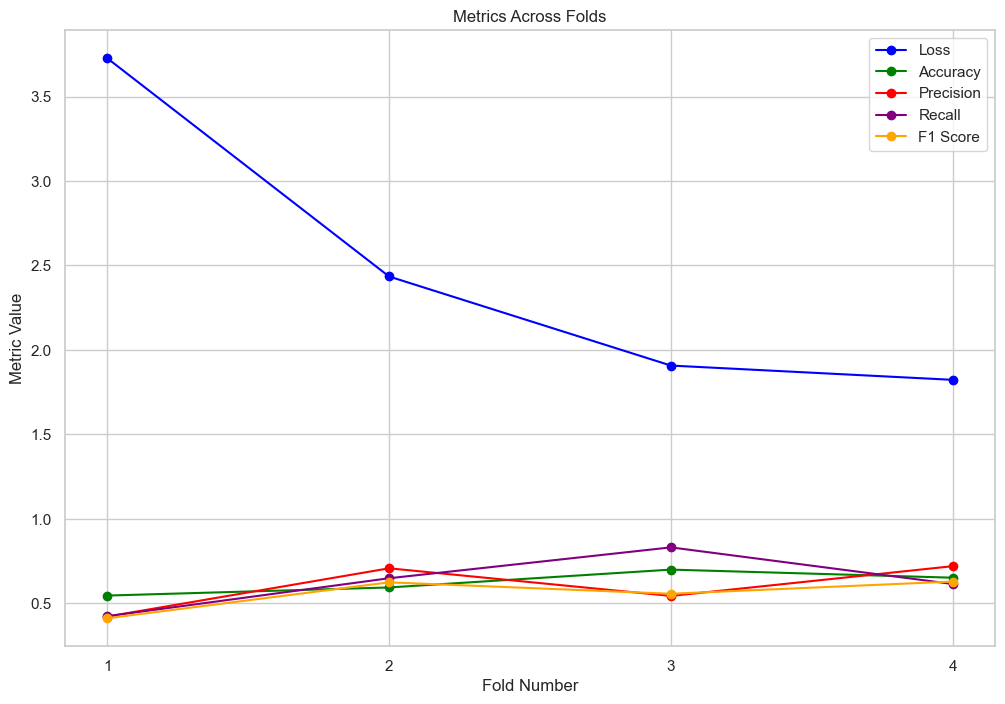

In [85]:
seed_5_folds_values = [unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1]

seed_5_training_acc_values = cv_training_acc_total

# Plotting all fold metrics|
seed_5_folds_plot = plot_all_metrics(unseen_losses, unseen_accuracies, unseen_precisions, unseen_recalls, unseen_f1, "Folds", "Fold Number")

## Majority Voting on Total Entries per cat_id 

In [86]:
# Debugging print statements
print(f'Checking - Cat IDs: {len(all_cat_ids)}, Predictions: {len(all_predicted_age_groups)}, Actuals: {len(all_actual_age_groups)}, Gender: {len(all_gender)}')

Checking - Cat IDs: 711, Predictions: 711, Actuals: 711, Gender: 711


In [87]:
# Create results df
full_results = pd.DataFrame({
    'cat_id': all_cat_ids,
    'predicted_age_group': all_predicted_age_groups,
    'actual_age_group': all_actual_age_groups,
    'all_gender': all_gender
})

# create a correct majority prediction column
full_results['correct'] = full_results['predicted_age_group'] == full_results['actual_age_group']

In [88]:
# Group by cat_id and aggregate predicted age groups
majority_votes = full_results.groupby('cat_id')['predicted_age_group'].agg(lambda x: x.mode()[0])
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first()

# Calculate the accuracy of majority voting
correct_predictions = (majority_votes == actual_groups).sum()
total_cats = len(actual_groups)
majority_vote_accuracy = correct_predictions / total_cats

logger(f"Overall Majority Vote Accuracy for cat_id: {majority_vote_accuracy:.2f} ({correct_predictions}/{total_cats})", file=log_file_path)

# store for final evaluation 
all_majority_vote_accuracies.append(majority_vote_accuracy)

Overall Majority Vote Accuracy for cat_id: 0.71 (78/110)


In [89]:
# Detailed df with predictions, actual labels, and comparison including majority vote
detailed_results = full_results.groupby('cat_id').apply(
    lambda x: pd.Series({
        'Predictions': list(x['predicted_age_group']),
        'Majority Vote': x['predicted_age_group'].mode()[0],
        'Actual Age Group': x['actual_age_group'].iloc[0],
        'Correct Majority Vote': x['predicted_age_group'].mode()[0] == x['actual_age_group'].iloc[0]
    })
).reset_index()

# Convert to DataFrame for better formatting and display
detailed_results = pd.DataFrame(detailed_results)

In [90]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

sorted_detailed_results = detailed_results.sort_values(by='Correct Majority Vote', ascending=False)

# Display the sorted DataFrame
sorted_detailed_results

,cat_id,Predictions,Majority Vote,Actual Age Group,Correct Majority Vote
0,000B,"[adult, senior, adult, adult, adult, adult, ad...",adult,adult,True
69,063A,"[adult, adult, adult, adult, adult, adult, adu...",adult,adult,True
81,075A,"[adult, adult, adult, adult, adult]",adult,adult,True
80,074A,"[senior, adult, kitten, adult, senior, senior,...",adult,adult,True
79,073A,"[senior, adult]",adult,adult,True
78,072A,"[adult, adult, adult, adult, adult, senior, ad...",adult,adult,True
77,071A,"[senior, adult, adult, adult, adult, senior, a...",adult,adult,True
76,070A,"[adult, adult, adult, adult, adult]",adult,adult,True
74,068A,"[senior, senior, adult, adult, senior, adult, ...",adult,adult,True
71,065A,"[senior, senior, adult, kitten, kitten, senior...",adult,adult,True


In [91]:
# Create df for majority votes
majority_df = majority_votes.reset_index()
majority_df.columns = ['cat_id', 'Majority_Vote']
# Get actual groups for each cat_id
actual_groups = full_results.groupby('cat_id')['actual_age_group'].first().reset_index()
# Merge majority votes with actual groups
majority_with_actual = pd.merge(majority_df, actual_groups, on='cat_id')
# Add a column to check if the majority vote was correct
majority_with_actual['Majority_Correct'] = majority_with_actual['Majority_Vote'] == majority_with_actual['actual_age_group']

# Calculate the class statistics
class_stats = majority_with_actual.groupby('actual_age_group').agg(
    accuracy=('Majority_Correct', lambda x: x.mean() * 100),
    total_count=('Majority_Correct', 'size')
).reset_index()

# store for final evaluation 
all_majority_vote_details.append(class_stats)

# Log detailed stats
print("Detailed Class Statistics for Majority Votes:")
print(class_stats)

Detailed Class Statistics for Majority Votes:
  actual_age_group   accuracy  total_count
0            adult  80.327869           61
1           kitten  60.000000           15
2           senior  58.823529           34


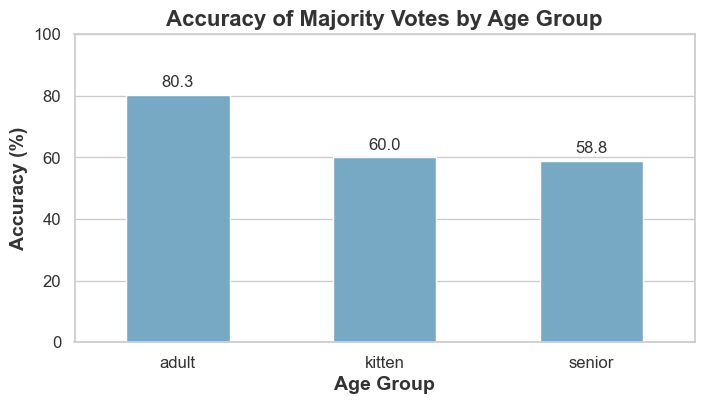

In [92]:
# Plot for Detailed Class Statistics for Majority Votes
styled_barplot(class_stats, 'actual_age_group', 'accuracy', 
               'Accuracy of Majority Votes by Age Group', 
               'Age Group', 'Accuracy (%)')


In [93]:
full_results

,cat_id,predicted_age_group,actual_age_group,all_gender,correct
0,015A,senior,senior,M,True
1,097B,adult,adult,X,True
2,019A,adult,adult,X,True
3,074A,senior,adult,M,False
4,020A,adult,adult,M,True
...,...,...,...,...,...
706,063A,adult,adult,X,True
707,047A,adult,kitten,X,False
708,047A,adult,kitten,X,False
709,059A,senior,senior,M,True


## Detailed Class Statistics

In [94]:
# For each fold
fold_class_stats = full_results.groupby('actual_age_group').agg(
    accuracy=('correct', lambda x: x.mean() * 100),
    total_count=('correct', 'size')
).reset_index()

# Store for final evaluation 
all_class_stats.append(fold_class_stats)

# Log the detailed stats
print("Detailed Class Statistics for this fold:")
print(fold_class_stats)

Detailed Class Statistics for this fold:
  actual_age_group   accuracy  total_count
0            adult  67.029973          367
1           kitten  48.351648           91
2           senior  60.869565          253


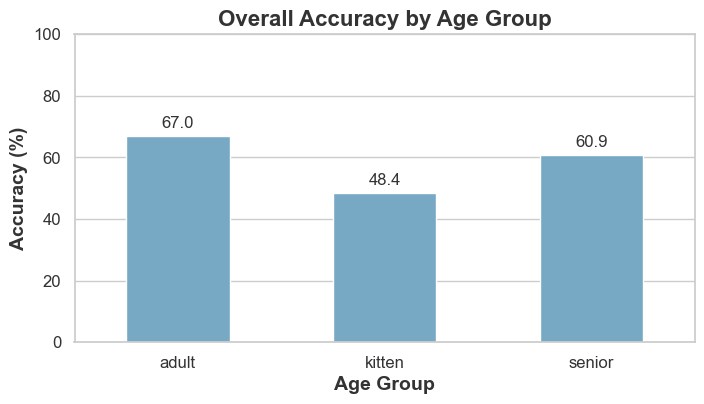

In [95]:
# Plot for Detailed Class Statistics (Overall)
styled_barplot(fold_class_stats, 'actual_age_group', 'accuracy', 
               'Overall Accuracy by Age Group', 
               'Age Group', 'Accuracy (%)')

## Gender Exploration

In [96]:
# Group by gender and calculate the total count, correct predictions, and accuracy
gender_stats = full_results.groupby('all_gender').agg(
    count=('cat_id', 'size'),  # Total number of cases per gender
    correct=('correct', 'sum')  # Sum of correct predictions per gender
).reset_index()

# Calculate accuracy for each gender
gender_stats['accuracy'] = (gender_stats['correct'] / gender_stats['count'] * 100).round(2)

# Display the DataFrame
print("Accuracy by Gender:")
print(gender_stats)

# store for final evaluation 
all_gender_stats.append(gender_stats)

Accuracy by Gender:
  all_gender  count  correct  accuracy
0          F    192      144     75.00
1          M    286      155     54.20
2          X    233      145     62.23


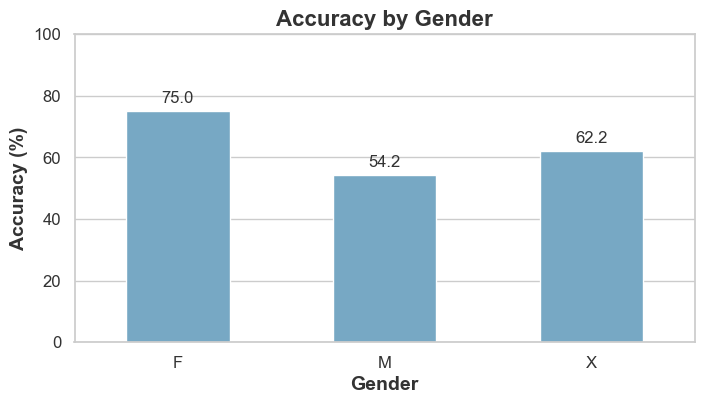

In [97]:
# Plot for Accuracy by Gender
styled_barplot(gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

### Log current total CV Stats

In [98]:
print("Total Majority Vote Accuracy so far:", all_majority_vote_accuracies)
print("Total Class Statistics so far:\n", all_class_stats) 
print("Total Majority Vote Statistics so far:\n", all_majority_vote_details) 
print("Total Gender Accuracy so far:\n", all_gender_stats)

Total Majority Vote Accuracy so far: [0.6909090909090909, 0.6363636363636364, 0.6818181818181818, 0.6818181818181818, 0.7090909090909091]
Total Class Statistics so far:
 [  actual_age_group   accuracy  total_count
0            adult  67.574932          367
1           kitten  59.000000          100
2           senior  63.636364          253,   actual_age_group   accuracy  total_count
0            adult  64.324324          370
1           kitten  44.680851           94
2           senior  59.288538          253,   actual_age_group   accuracy  total_count
0            adult  68.834688          369
1           kitten  53.846154           91
2           senior  57.312253          253,   actual_age_group   accuracy  total_count
0            adult  72.467532          385
1           kitten  56.842105           95
2           senior  56.916996          253,   actual_age_group   accuracy  total_count
0            adult  67.029973          367
1           kitten  48.351648           91
2       

# --------------

# Total Final Results & Analysis

In [99]:
# Count unique cat_id per age group 
unique_cats_per_age_group = dataframe.groupby('age_group')['cat_id'].nunique()

# Display the counts
print("Unique cat_id counts in original dataframe:", unique_cats_per_age_group)

Unique cat_id counts in original dataframe: age_group
adult     62
kitten    16
senior    34
Name: cat_id, dtype: int64


## Metrics

In [100]:
# Calculate overall metrics
overall_avg_loss = np.mean(all_losses)
overall_avg_acc = np.mean(all_accuracies)
overall_avg_precision = np.mean(all_precisions)
overall_avg_recall = np.mean(all_recalls)
overall_avg_f1 = np.mean(all_f1)

print("Overall Average Metrics:")
print("Loss:", overall_avg_loss)
print("Accuracy:", overall_avg_acc)
print("Precision:", overall_avg_precision)
print("Recall:", overall_avg_recall)
print("F1 Score:", overall_avg_f1)

Overall Average Metrics:
Loss: 2.4615478813648224
Accuracy: 0.6337234407663346
Precision: 0.6263402078169382
Recall: 0.6261497712702356
F1 Score: 0.5959558811707104


## Majority Votes

In [101]:
# After calculating class_stats for each fold
all_majority_vote_details.append(class_stats)

# At the end, when calculating the final metrics:
total_majority_vote_details = pd.concat(all_majority_vote_details)

macro_avg_majority_vote_accuracy = (
    total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean().mean()
)

print(f"Macro-Averaged Majority Vote Accuracy: {macro_avg_majority_vote_accuracy}")

# For class-wise accuracies:
macro_avg_class_accuracies = total_majority_vote_details.groupby('actual_age_group')['accuracy'].mean()

print("Macro-Averaged Class Accuracies:")
print(macro_avg_class_accuracies)

macro_avg_class_accuracies_df = macro_avg_class_accuracies.reset_index()
macro_avg_class_accuracies_df.columns = ['actual_age_group', 'accuracy']

Macro-Averaged Majority Vote Accuracy: 67.0163220115004
Macro-Averaged Class Accuracies:
actual_age_group
adult     74.316940
kitten    68.888889
senior    57.843137
Name: accuracy, dtype: float64


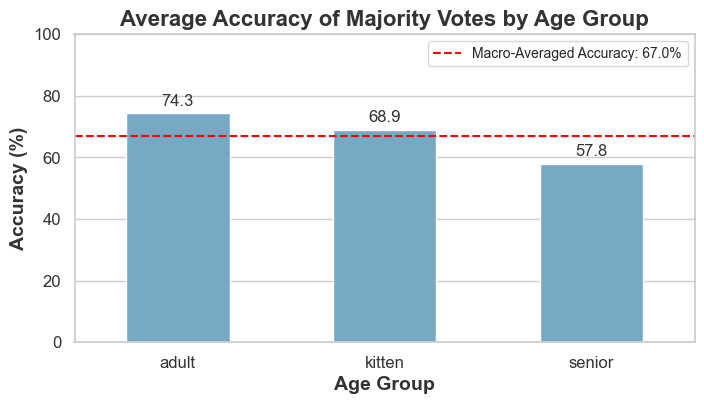

In [102]:
# Use the modified function
styled_barplot_with_average(macro_avg_class_accuracies_df, 'actual_age_group', 'accuracy', 
                            'Average Accuracy of Majority Votes by Age Group', 
                            'Age Group', 'Accuracy (%)', 
                            average_line=macro_avg_majority_vote_accuracy)

## Detailed Class Statistics

In [103]:
# Calculate the average class statistics across all folds and seeds
average_class_stats = pd.concat(all_class_stats).groupby('actual_age_group').agg({
    'accuracy': 'mean',
    'total_count': 'mean'
}).reset_index()
print("Average Class Statistics across all folds and seeds:")
print(average_class_stats)

# Calculate macro-averaged accuracy
macro_accuracy = average_class_stats['accuracy'].mean()
print(f"Macro-Averaged Accuracy: {macro_accuracy:.2f}%")

# Calculate macro-averaged accuracy for detailed class statistics
macro_avg_class_accuracy = average_class_stats['accuracy'].mean()

Average Class Statistics across all folds and seeds:
  actual_age_group   accuracy  total_count
0            adult  68.046290        371.6
1           kitten  52.544152         94.2
2           senior  59.604743        253.0
Macro-Averaged Accuracy: 60.07%


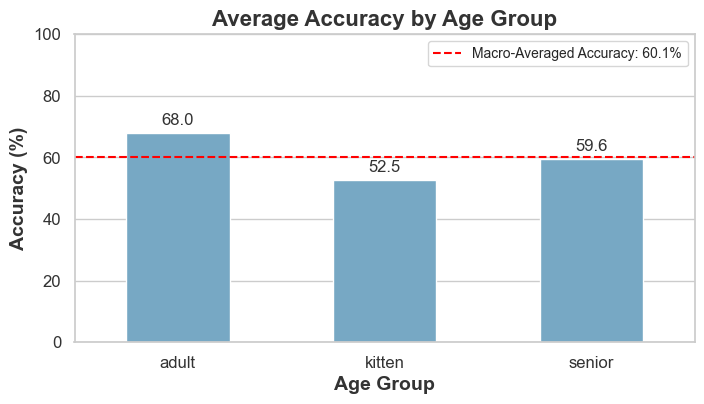

In [104]:
# Use the modified function for detailed class statistics
styled_barplot_with_average(average_class_stats, 'actual_age_group', 'accuracy', 
                            'Average Accuracy by Age Group', 
                            'Age Group', 'Accuracy (%)', 
                            average_line=macro_avg_class_accuracy)

In [105]:
# Concatenate all gender stats DataFrames and calculate the mean of accuracies
total_gender_stats = pd.concat(all_gender_stats)
average_gender_stats = total_gender_stats.groupby('all_gender').agg({
    'count': 'sum',  
    'correct': 'sum'  
}).reset_index()
average_gender_stats['accuracy'] = (average_gender_stats['correct'] / average_gender_stats['count']) * 100

print("Average Gender Accuracy:")
print(average_gender_stats)

Average Gender Accuracy:
  all_gender  count  correct   accuracy
0          F    979      703  71.807967
1          M   1437      812  56.506611
2          X   1178      752  63.837012


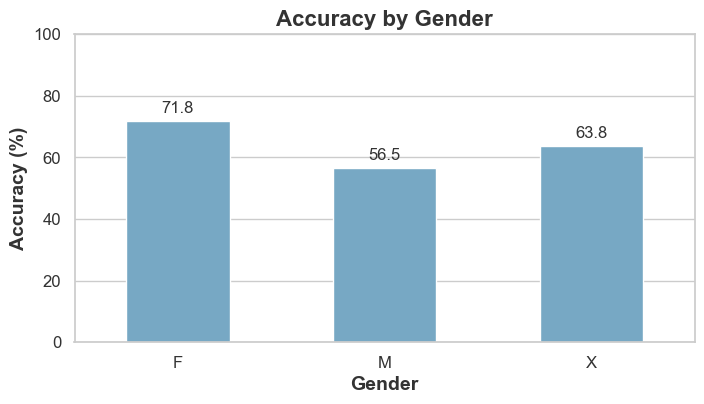

In [106]:
# Plot for Accuracy by Gender
styled_barplot(total_gender_stats, 'all_gender', 'accuracy', 
               'Accuracy by Gender', 
               'Gender', 'Accuracy (%)')

# Visualisations

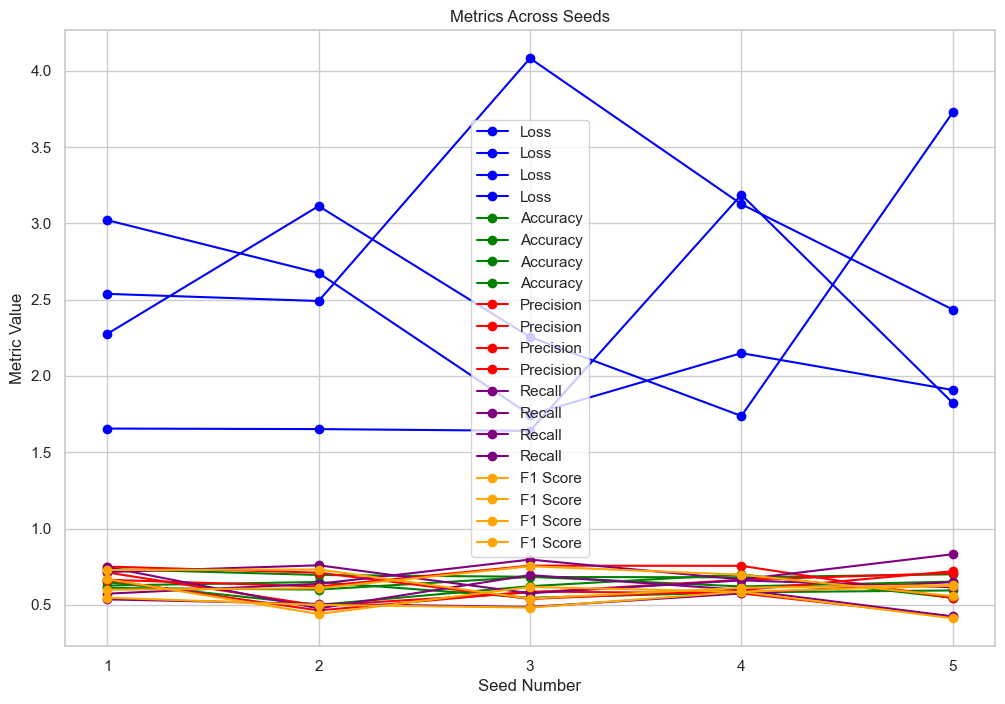

In [107]:
# Plotting all metrics
metrics_across_seeds = plot_all_metrics(all_losses, all_accuracies, all_precisions, all_recalls, all_f1, "Seeds", "Seed Number")

## Display the seed folds results together

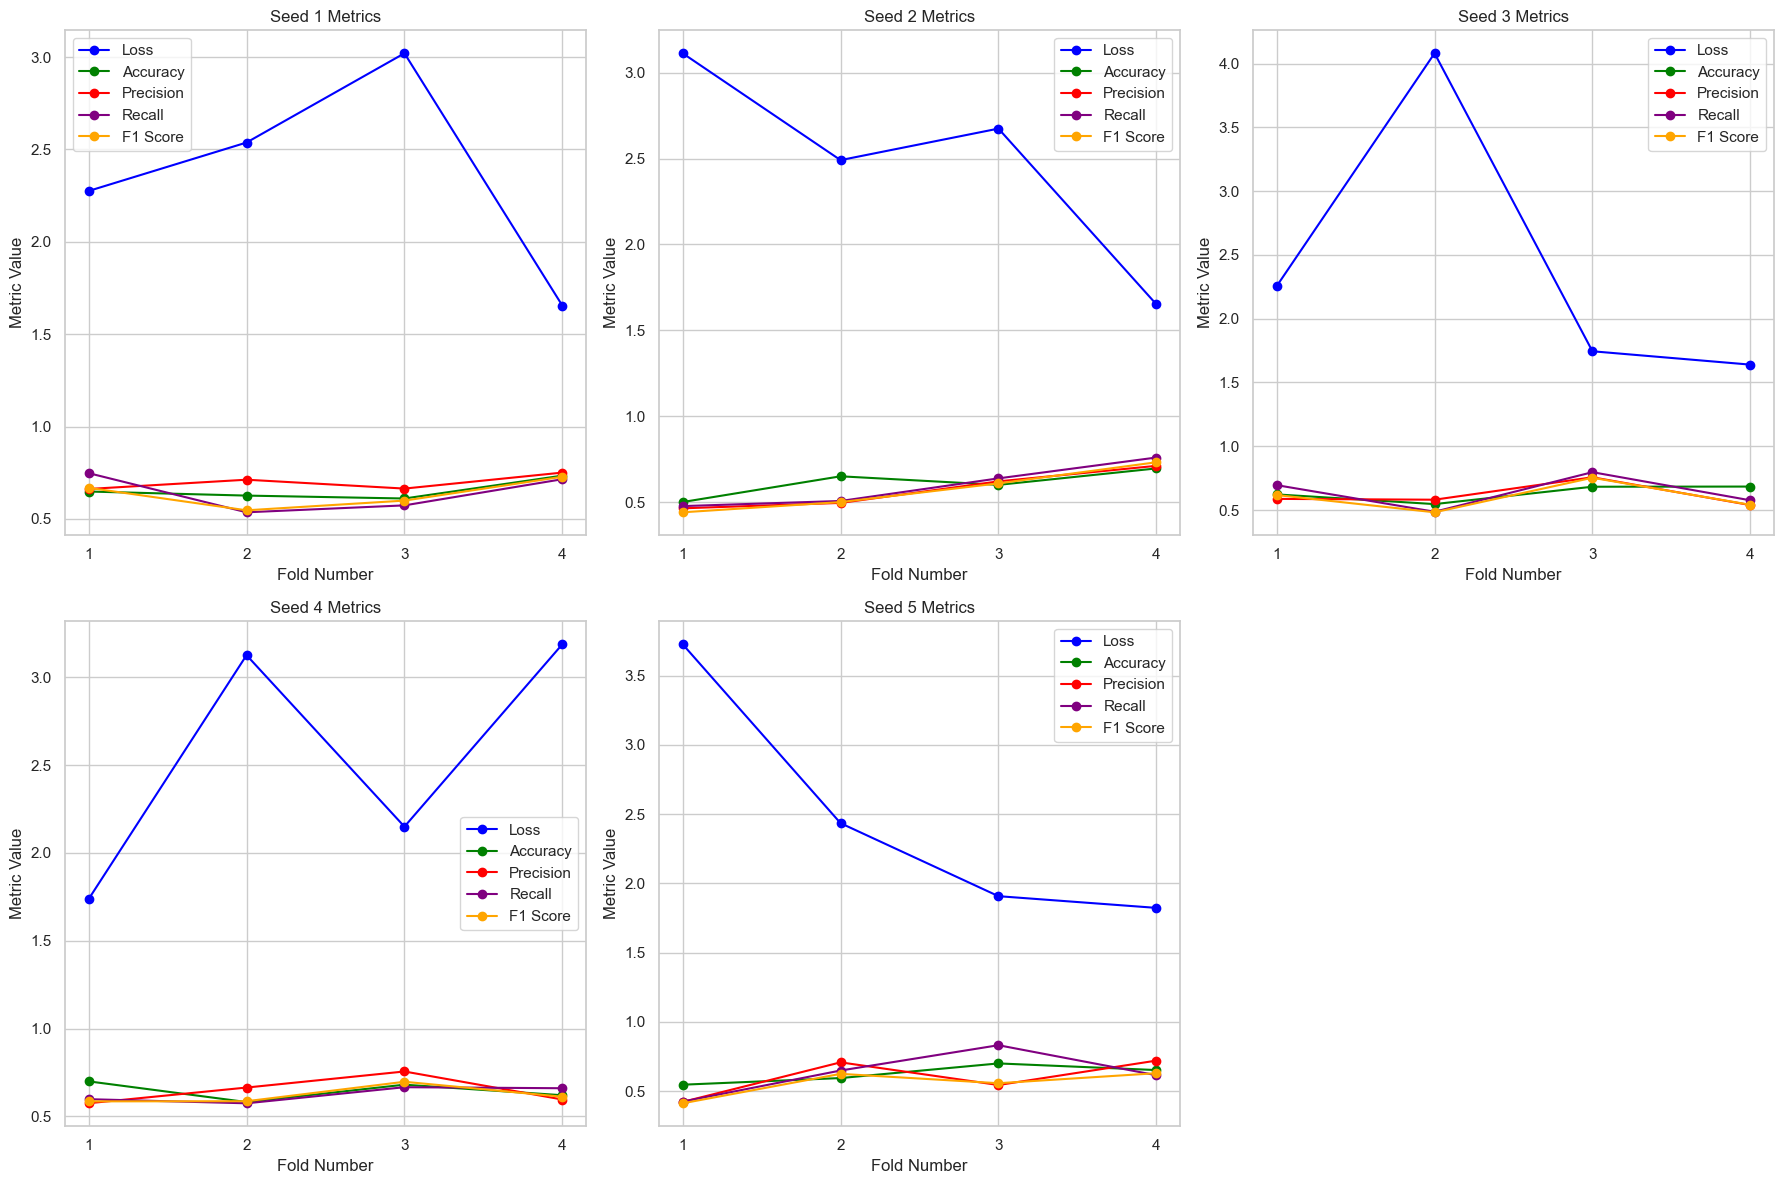

In [108]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))  

# Flatten the axes array for easier indexing
axes = axes.flatten()

def plot_metrics_on_axes(ax, losses, accuracies, precisions, recalls, f1, title):
    ax.plot(range(1, len(losses)+1), losses, marker='o', color='blue', label='Loss')
    ax.plot(range(1, len(accuracies)+1), accuracies, marker='o', color='green', label='Accuracy')
    ax.plot(range(1, len(precisions)+1), precisions, marker='o', color='red', label='Precision')
    ax.plot(range(1, len(recalls)+1), recalls, marker='o', color='purple', label='Recall')
    ax.plot(range(1, len(f1)+1), f1, marker='o', color='orange', label='F1 Score')
    ax.set_xticks([1, 2, 3, 4])  # Set x-axis ticks to full integers
    ax.set_title(title)
    ax.set_xlabel('Fold Number')
    ax.set_ylabel('Metric Value')
    ax.legend()
    ax.grid(True)

# Plot onto each axes object
plot_metrics_on_axes(axes[0], *seed_1_folds_values, "Seed 1 Metrics")
plot_metrics_on_axes(axes[1], *seed_2_folds_values, "Seed 2 Metrics")
plot_metrics_on_axes(axes[2], *seed_3_folds_values, "Seed 3 Metrics")
plot_metrics_on_axes(axes[3], *seed_4_folds_values, "Seed 4 Metrics")
plot_metrics_on_axes(axes[4], *seed_5_folds_values, "Seed 5 Metrics")

# Hide the unused subplot 
for ax in axes[5:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

# Statistics

In [109]:
# Calculate the standard deviation for each metric
std_loss = np.std(all_losses)
std_accuracy = np.std(all_accuracies)
std_precision = np.std(all_precisions)
std_recall = np.std(all_recalls)
std_f1 = np.std(all_f1)

print("Standard Deviations:")
print(f"Loss: {std_loss}")
print(f"Accuracy: {std_accuracy}")
print(f"Precision: {std_precision}")
print(f"Recall: {std_recall}")
print(f"F1 Score: {std_f1}")

Standard Deviations:
Loss: 0.7031893300112941
Accuracy: 0.05914717179533163
Precision: 0.09759747498532441
Recall: 0.10815465439352716
F1 Score: 0.09116926234582005


In [110]:
# Calculate the interquartile range for each metric
iqr_loss = np.percentile(all_losses, 75) - np.percentile(all_losses, 25)
iqr_accuracy = np.percentile(all_accuracies, 75) - np.percentile(all_accuracies, 25)
iqr_precision = np.percentile(all_precisions, 75) - np.percentile(all_precisions, 25)
iqr_recall = np.percentile(all_recalls, 75) - np.percentile(all_recalls, 25)
iqr_f1 = np.percentile(all_f1, 75) - np.percentile(all_f1, 25)

print("Interquartile Ranges:")
print(f"Loss: {iqr_loss}")
print(f"Accuracy: {iqr_accuracy}")
print(f"Precision: {iqr_precision}")
print(f"Recall: {iqr_recall}")
print(f"F1 Score: {iqr_f1}")


Interquartile Ranges:
Loss: 1.2401325702667236
Accuracy: 0.08418712019920349
Precision: 0.1437550471984168
Recall: 0.13598421367085722
F1 Score: 0.09395707821018284


### Variation

In [111]:
# Calculate the variation for each metric
var_loss = np.var(all_losses)
var_accuracy = np.var(all_accuracies)
var_precision = np.var(all_precisions)
var_recall = np.var(all_recalls)
var_f1 = np.var(all_f1)

print("Variations:")
print(f"Loss: {var_loss}")
print(f"Accuracy: {var_accuracy}")
print(f"Precision: {var_precision}")
print(f"Recall: {var_recall}")
print(f"F1 Score: {var_f1}")

Variations:
Loss: 0.49447523384173275
Accuracy: 0.0034983879313864735
Precision: 0.009525267123511025
Recall: 0.011697429266983302
F1 Score: 0.008311834396680961


### Levene tests for variation significance between seeds

#### Levene across seeds for LOSS

In [112]:
# Levene across seeds for LOSS
stat_val, p_val = levene(seed_1_folds_values[0], seed_2_folds_values[0], seed_3_folds_values[0], seed_4_folds_values[0], seed_5_folds_values[0])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.27, P-value: 0.893


#### Levene across seeds for ACCURACY

In [113]:
# Levene across seeds for ACCURACY
stat_val, p_val = levene(seed_1_folds_values[1], seed_2_folds_values[1], seed_3_folds_values[1], seed_4_folds_values[1], seed_5_folds_values[1])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.27, P-value: 0.895


#### Levene across seeds for PRECISION

In [114]:
# Levene across seeds for PRECISION
stat_val, p_val = levene(seed_1_folds_values[2], seed_2_folds_values[2], seed_3_folds_values[2], seed_4_folds_values[2], seed_5_folds_values[2])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 1.47, P-value: 0.261


#### Levene across seeds for RECALL

In [115]:
# Levene across seeds for RECALL
stat_val, p_val = levene(seed_1_folds_values[3], seed_2_folds_values[3], seed_3_folds_values[3], seed_4_folds_values[3], seed_5_folds_values[3])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.96, P-value: 0.458


#### Levene across seeds for F1

In [116]:
# Levene across seeds for F1
stat_val, p_val = levene(seed_1_folds_values[4], seed_2_folds_values[4], seed_3_folds_values[4], seed_4_folds_values[4], seed_5_folds_values[4])
print(f'levene test statistic: {stat_val:.2f}, P-value: {p_val:.3f}')

levene test statistic: 0.81, P-value: 0.540


## Print out measurements for future further analysis (without rerunning notebook)

In [117]:
seed_1_folds_values

[[2.2753818035125732,
  2.5375308990478516,
  3.0206429958343506,
  1.6550275087356567],
 [0.6482412219047546,
  0.6262136101722717,
  0.6104651093482971,
  0.7342657446861267],
 [0.6620580108952202,
  0.7121913580246915,
  0.6641711229946524,
  0.7507155867811606],
 [0.7476132849267177,
  0.5357598978288634,
  0.5732299620798919,
  0.7148546395858224],
 [0.6681685273790537,
  0.546553598608393,
  0.5990713482482779,
  0.7281577707081418]]

In [118]:
seed_2_folds_values

[[3.112839937210083,
  2.4907634258270264,
  2.674304723739624,
  1.6515061855316162],
 [0.5, 0.6497696042060852, 0.6000000238418579, 0.695652186870575],
 [0.4633658522547411,
  0.49484754803903735,
  0.6202150537634409,
  0.7107167004732927],
 [0.4762962962962963,
  0.5061173533083646,
  0.6377819627537141,
  0.759120022277917],
 [0.4401919629192356,
  0.49967709885742667,
  0.6085631925326581,
  0.7315336992756348]]

In [119]:
seed_3_folds_values

[[2.2553765773773193,
  4.0813751220703125,
  1.7446887493133545,
  1.6399449110031128],
 [0.6222222447395325,
  0.5463414788246155,
  0.6824644804000854,
  0.6837607026100159],
 [0.5871635610766046,
  0.5807126854077745,
  0.7566760037348272,
  0.5384703196347033],
 [0.6948439997220485,
  0.4861175641630402,
  0.7965367965367965,
  0.5760348583877996],
 [0.6172483173494298,
  0.48197868587939513,
  0.7528344671201813,
  0.5408884163846271]]

In [120]:
seed_4_folds_values

[[1.737455129623413, 3.125311851501465, 2.149271011352539, 3.1872897148132324],
 [0.6994219422340393,
  0.5816993713378906,
  0.680497944355011,
  0.6204819083213806],
 [0.5750605326876513,
  0.6641975308641975,
  0.7556721056721055,
  0.5961538461538461],
 [0.5979905437352245,
  0.5745718050065877,
  0.6661877394636014,
  0.6603256122698529],
 [0.5855725286065844,
  0.5863886861052662,
  0.6971193572178794,
  0.611837327523602]]

In [121]:
all_best_training_acc

[1.0,
 0.9982964396476746,
 1.0,
 0.9984615445137024,
 1.0,
 0.9982638955116272,
 0.9904458522796631,
 0.998525083065033,
 1.0,
 1.0,
 0.9965635538101196,
 0.9940828680992126,
 0.9983870983123779,
 1.0,
 1.0,
 0.9984050989151001,
 1.0,
 0.9969230890274048,
 1.0,
 0.9934318661689758]

In [122]:
total_training_acc

[[0.5740740895271301,
  0.8131313323974609,
  0.868686854839325,
  0.9057239294052124,
  0.9276094436645508,
  0.9562289714813232,
  0.9713804721832275,
  0.9713804721832275,
  0.9663299918174744,
  0.9713804721832275,
  0.9865319728851318,
  0.9713804721832275,
  0.9848484992980957,
  0.9680134654045105,
  0.9646464586257935,
  0.9797979593276978,
  0.9882155060768127,
  0.9814814925193787,
  0.9730639457702637,
  0.9764309525489807,
  0.9898989796638489,
  0.9612794518470764,
  0.9814814925193787,
  0.9848484992980957,
  0.9898989796638489,
  0.9848484992980957,
  0.9915825128555298,
  0.9865319728851318,
  0.9831649661064148,
  0.9949495196342468,
  0.9898989796638489,
  0.9882155060768127,
  0.9814814925193787,
  0.9814814925193787,
  0.9595959782600403,
  0.9865319728851318,
  0.9747474789619446,
  0.9797979593276978,
  0.9764309525489807,
  0.9949495196342468,
  0.9730639457702637,
  0.9831649661064148,
  0.9882155060768127,
  0.9932659864425659,
  0.9882155060768127,
  0.9831649

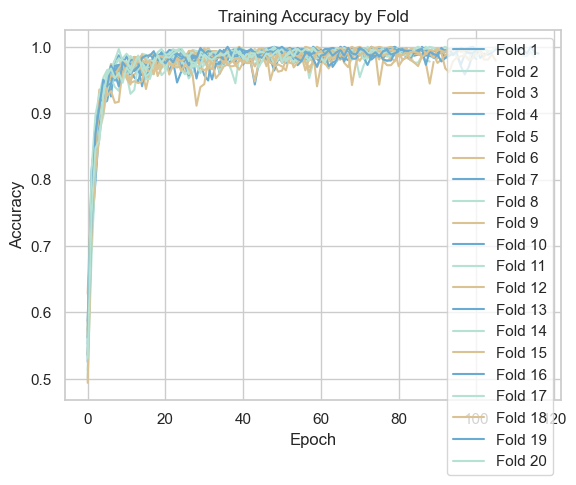

In [123]:
# Plot accuracy histories for all folds
for i, fold_accuracy in enumerate(total_training_acc):
    plt.plot(fold_accuracy, label=f'Fold {i+1}')

plt.title('Training Accuracy by Fold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig("Perch_categorical_training_accuracy")

plt.legend()
plt.show()

In [124]:
# running time including analysis
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 161.65094590187073 seconds
